### Análisis de Servicio de Deuda y Clasificación de Productores de Caña MX

Este análisis forma parte del problema de optimización de recursos para el **Ecosistema de Producción de Caña en MX**.

Para ello se estudia la información de los productores de caña relacionada a: *Productividad de Caña Proyectada de los terrenos, Obligaciones Financieras Existentes y Obligaciones Financieras Proyectadas*, con el objetivo de estimar **Cocientes Deuda-Ingreso**, **Probabilidades de Impago** y una **Clasificación Financiera** de los Productores.

Las obligaciones *Financieras Proyectadas* son una función del tipo de labor que se requiere en el (los) terreno(s) del productor:
- Siembra (Adecuación, Preparación, Siembra y Manejo).
- Manejo de Plantación.

Para el caso de la **siembra**, se estima que *el primer corte ocurra entre los 12 y 14 meses siguientes* y por lo tanto este período debe considerarse para la proyección de ingresos. En el caso del **manejo**, deberá conocerse el número de corte que se proyecta para los siguientes años (segundo, tercero o cuarto), para poder estimar correctamente el nivel de degradación de productividad del terreno.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

### Datos de Productividad por Productor MX

El conjunto de datos utilizados para estimar la productividad de los terrenos se basa en el *desempeño histórico, el tercio cosechado y la proyección de degradación de productividad* basada en el número de cortes entre los períodos de renovación.

Dado que un *productor* puede tener uno o varios terrenos, se muestra el **promedio ponderado de la productividad** por productor.

#### EMSA

In [2]:
df_productividad_emsa = pd.read_csv(r'EMSA.csv')
df_productividad_emsa = df_productividad_emsa[['Ingenio','NUMERO CAÑERO','Area total','TCH Base','TCH 2','TCH 3','TCH 4','TCH 5']]

# Proyección fuera de la ventana de renovación
df_productividad_emsa['TCH 6'] = df_productividad_emsa['TCH 5']
df_productividad_emsa['TCH 7'] = df_productividad_emsa['TCH 6']
df_productividad_emsa['TCH 8'] = df_productividad_emsa['TCH 7']
df_productividad_emsa['TCH 9'] = df_productividad_emsa['TCH 8']
df_productividad_emsa['TCH 10'] = df_productividad_emsa['TCH 9']

df_productividad_emsa = df_productividad_emsa.melt(id_vars=['Ingenio','NUMERO CAÑERO','Area total'],
        var_name='CORTE',
        value_name='TCH')

df_productividad_emsa.loc[df_productividad_emsa['CORTE']=='TCH Base','CORTE'] = 1 # TCH Primer Corte
df_productividad_emsa.loc[df_productividad_emsa['CORTE']=='TCH 2','CORTE'] = 2  # TCH Segundo Corte
df_productividad_emsa.loc[df_productividad_emsa['CORTE']=='TCH 3','CORTE'] = 3  # TCH Tercer Corte
df_productividad_emsa.loc[df_productividad_emsa['CORTE']=='TCH 4','CORTE'] = 4  # TCH Cuarto Corte
df_productividad_emsa.loc[df_productividad_emsa['CORTE']=='TCH 5','CORTE'] = 5  # TCH Quinto Corte

# Proyección fuera de la ventana de renovación
df_productividad_emsa.loc[df_productividad_emsa['CORTE']=='TCH 6','CORTE'] = 6  # TCH Sexto Corte
df_productividad_emsa.loc[df_productividad_emsa['CORTE']=='TCH 7','CORTE'] = 7  # TCH Septimo Corte
df_productividad_emsa.loc[df_productividad_emsa['CORTE']=='TCH 8','CORTE'] = 8  # TCH Octavo Corte
df_productividad_emsa.loc[df_productividad_emsa['CORTE']=='TCH 9','CORTE'] = 9  # TCH Noveno Corte
df_productividad_emsa.loc[df_productividad_emsa['CORTE']=='TCH 10','CORTE'] = 10  # TCH Décimo Corte

df_productividad_emsa.sort_values(['NUMERO CAÑERO','CORTE'],axis=0,inplace=True)
df_productividad_emsa

,Ingenio,NUMERO CAÑERO,Area total,CORTE,TCH
0,Mante,5101009,27.0,1,56.020000
2017,Mante,5101009,27.0,2,43.094741
4034,Mante,5101009,27.0,3,40.501992
6051,Mante,5101009,27.0,4,39.529697
8068,Mante,5101009,27.0,5,38.880256
...,...,...,...,...,...
12101,Mante,5996001,6.0,6,44.569279
14118,Mante,5996001,6.0,7,44.569279
16135,Mante,5996001,6.0,8,44.569279
18152,Mante,5996001,6.0,9,44.569279


#### IPSA

In [3]:
df_productividad_ipsa = pd.read_csv(r'IPSA.csv')
df_productividad_ipsa = df_productividad_ipsa[['Ingenio','NUMERO CAÑERO','Area total','TCH Base','TCH 2','TCH 3','TCH 4','TCH 5']]

# Proyección fuera de la ventana de renovación
df_productividad_ipsa['TCH 6'] = df_productividad_ipsa['TCH 5']
df_productividad_ipsa['TCH 7'] = df_productividad_ipsa['TCH 6']
df_productividad_ipsa['TCH 8'] = df_productividad_ipsa['TCH 7']
df_productividad_ipsa['TCH 9'] = df_productividad_ipsa['TCH 8']
df_productividad_ipsa['TCH 10'] = df_productividad_ipsa['TCH 9']

df_productividad_ipsa = df_productividad_ipsa.melt(id_vars=['Ingenio','NUMERO CAÑERO','Area total'],
        var_name='CORTE',
        value_name='TCH')

df_productividad_ipsa.loc[df_productividad_ipsa['CORTE']=='TCH Base','CORTE'] = 1 # TCH Primer Corte
df_productividad_ipsa.loc[df_productividad_ipsa['CORTE']=='TCH 2','CORTE'] = 2  # TCH Segundo Corte
df_productividad_ipsa.loc[df_productividad_ipsa['CORTE']=='TCH 3','CORTE'] = 3  # TCH Tercer Corte
df_productividad_ipsa.loc[df_productividad_ipsa['CORTE']=='TCH 4','CORTE'] = 4  # TCH Cuarto Corte
df_productividad_ipsa.loc[df_productividad_ipsa['CORTE']=='TCH 5','CORTE'] = 5  # TCH Quinto Corte

# Proyección fuera de la ventana de renovación
df_productividad_ipsa.loc[df_productividad_ipsa['CORTE']=='TCH 6','CORTE'] = 6  # TCH Sexto Corte
df_productividad_ipsa.loc[df_productividad_ipsa['CORTE']=='TCH 7','CORTE'] = 7  # TCH Septimo Corte
df_productividad_ipsa.loc[df_productividad_ipsa['CORTE']=='TCH 8','CORTE'] = 8  # TCH Octavo Corte
df_productividad_ipsa.loc[df_productividad_ipsa['CORTE']=='TCH 9','CORTE'] = 9  # TCH Noveno Corte
df_productividad_ipsa.loc[df_productividad_ipsa['CORTE']=='TCH 10','CORTE'] = 10  # TCH Décimo Corte

df_productividad_ipsa.sort_values(['NUMERO CAÑERO','CORTE'],axis=0,inplace=True)
df_productividad_ipsa


,Ingenio,NUMERO CAÑERO,Area total,CORTE,TCH
2430,IPSA,#VALUE!,3.0,1,62.890000
4861,IPSA,#VALUE!,3.0,2,55.000000
7292,IPSA,#VALUE!,3.0,3,49.970706
9723,IPSA,#VALUE!,3.0,4,51.749960
12154,IPSA,#VALUE!,3.0,5,53.100110
...,...,...,...,...,...
14584,IPSA,3757002,6.5,6,53.100110
17015,IPSA,3757002,6.5,7,53.100110
19446,IPSA,3757002,6.5,8,53.100110
21877,IPSA,3757002,6.5,9,53.100110


In [4]:
df_productividad = pd.concat([df_productividad_emsa,df_productividad_ipsa])
df_productividad

,Ingenio,NUMERO CAÑERO,Area total,CORTE,TCH
0,Mante,5101009,27.0,1,56.020000
2017,Mante,5101009,27.0,2,43.094741
4034,Mante,5101009,27.0,3,40.501992
6051,Mante,5101009,27.0,4,39.529697
8068,Mante,5101009,27.0,5,38.880256
...,...,...,...,...,...
14584,IPSA,3757002,6.5,6,53.100110
17015,IPSA,3757002,6.5,7,53.100110
19446,IPSA,3757002,6.5,8,53.100110
21877,IPSA,3757002,6.5,9,53.100110


### Información Financiera de Productores MX

El conjunto de datos financieros incluye información de obligaciones previas y existentes de los productores, así como las cuotas que son fijas.

In [5]:
pd.options.display.max_columns = None
df_financiero = pd.read_csv(r'Productores.csv')
df_financiero = df_financiero[['NUMERO CAÑERO','NOMBRE','SIEMBRA','CORTE','ZAFRA','HECTAREAS','SALDOS DESCTOS. TERCEROS','SALDOS INGENIO','Imss Cuota']]
df_financiero.loc[df_financiero['ZAFRA']=='2023/2024','ZAFRA'] = -1 # Zafra pasada, que incluye obligaciones adquiridas previamente por el Productor.
df_financiero.loc[df_financiero['ZAFRA']=='2024/2025','ZAFRA'] = 0  # Zafra próxima, en la cual se espera tener siembra (NO PRODUCTIVA) o manejo.
df_financiero.loc[df_financiero['ZAFRA']=='2025/2026','ZAFRA'] = 1  # Zafra AÑO 1, en la cual se espera tener el primer corte de caña (siembra) o mayor (manejo).
df_financiero.loc[df_financiero['ZAFRA']=='2026/2027','ZAFRA'] = 2  # Zafra AÑO 2, en la cual se espera tener el segundo corte de caña (siembra) o mayor (manejo).

df_financiero.rename(columns={'SALDOS DESCTOS. TERCEROS': 'FINANCIERAS','Imss Cuota': 'CUOTA IMSS' }, inplace=True)

df_financiero

,NUMERO CAÑERO,NOMBRE,SIEMBRA,CORTE,ZAFRA,HECTAREAS,FINANCIERAS,SALDOS INGENIO,CUOTA IMSS
0,5101009,RENOVACION AGROPECUARIA S.P.R. DE R.L.,0,0,-1,85.5,0.00,734041.45,NaN
1,5101009,RENOVACION AGROPECUARIA S.P.R. DE R.L.,1,0,0,85.5,0.00,814977.45,NaN
2,5101009,RENOVACION AGROPECUARIA S.P.R. DE R.L.,1,1,1,85.5,0.00,814977.45,NaN
3,5101009,RENOVACION AGROPECUARIA S.P.R. DE R.L.,1,2,2,85.5,0.00,814977.45,NaN
4,5101011,"LA PEÑITA DE XICO, S.P.R. DE R.L.",0,0,-1,46.0,165323.56,332178.98,NaN
...,...,...,...,...,...,...,...,...,...
15015,5994001,"JALAPEÑOS Y SERRANOS, SPR RL",0,3,2,8.0,0.00,151200.00,NaN
15016,5994002,"MACAIL, SPR DR RL",0,0,-1,34.0,1296854.35,859756.57,NaN
15017,5994002,"MACAIL, SPR DR RL",1,0,0,34.0,618320.18,649261.29,NaN
15018,5994002,"MACAIL, SPR DR RL",1,1,1,34.0,372463.44,649261.29,NaN


### Llenado de Información Financiera Faltante

In [6]:
df_financiero_pivot = df_financiero.pivot_table(index=['NUMERO CAÑERO'], 
            columns=['ZAFRA'],values=['SIEMBRA','CORTE','HECTAREAS','FINANCIERAS','SALDOS INGENIO','CUOTA IMSS']).fillna(0)

#Información Faltante de Hectáreas
df_financiero_pivot[('HECTAREAS',3)] = df_financiero_pivot[('HECTAREAS',2)]
df_financiero_pivot[('HECTAREAS',4)] = df_financiero_pivot[('HECTAREAS',3)]

# Información Faltante de Financieras
df_financiero_pivot[('FINANCIERAS',3)] = df_financiero_pivot[('FINANCIERAS',2)]
df_financiero_pivot[('FINANCIERAS',4)] = df_financiero_pivot[('FINANCIERAS',3)]

# Información Faltante de Saldos Ingenio
df_financiero_pivot[('SALDOS INGENIO',3)] = df_financiero_pivot[('SALDOS INGENIO',2)]
df_financiero_pivot[('SALDOS INGENIO',4)] = df_financiero_pivot[('SALDOS INGENIO',3)]

# Información Faltante de Cuota IMSS
df_financiero_pivot[('CUOTA IMSS',3)] = df_financiero_pivot[('CUOTA IMSS',2)]
df_financiero_pivot[('CUOTA IMSS',4)] = df_financiero_pivot[('CUOTA IMSS',3)] 

#Información Faltante de Siembra
df_financiero_pivot[('SIEMBRA',3)] = df_financiero_pivot[('SIEMBRA',0)]
df_financiero_pivot[('SIEMBRA',4)] = df_financiero_pivot[('SIEMBRA',0)]

#Información Faltante de Número de Corte
df_financiero_pivot[('CORTE',3)] = df_financiero_pivot[('CORTE',2)] + 1
df_financiero_pivot[('CORTE',4)] = df_financiero_pivot[('CORTE',3)] + 1

df_financiero_pivot = df_financiero_pivot.sort_index(axis=1)
df_financiero_pivot

CORTE                          CUOTA IMSS                      \
ZAFRA            -1    0    1    2    3    4         -1         0         1   
NUMERO CAÑERO                                                                 
5101009         0.0  0.0  1.0  2.0  3.0  4.0       0.00      0.00      0.00   
5101011         0.0  2.0  3.0  4.0  5.0  6.0       0.00      0.00      0.00   
5101012         0.0  1.0  2.0  3.0  4.0  5.0       0.00      0.00      0.00   
5101013         0.0  0.0  1.0  2.0  3.0  4.0   20462.27  20462.27  20462.27   
5101117         0.0  0.0  1.0  2.0  3.0  4.0   20462.27  20462.27  20462.27   
...             ...  ...  ...  ...  ...  ...        ...       ...       ...   
5993001         0.0  1.0  2.0  3.0  4.0  5.0   20462.27  20462.27  20462.27   
5993002         0.0  0.0  1.0  2.0  3.0  4.0       0.00      0.00      0.00   
5993003         0.0  0.0  1.0  2.0  3.0  4.0   20462.27  20462.27  20462.27   
5994001         0.0  1.0  2.0  3.0  4.0  5.0       0.00      0.00      0.00   
5994002         0.0  0.0  1.0  2.0  3.0  4.0       0.00      0.00      0.00   

                                            FINANCIERAS                        \
ZAFRA                 2         3         4          -1          0          1   
NUMERO CAÑERO                                                                   
5101009            0.00      0.00      0.00        0.00       0.00       0.00   
5101011            0.00      0.00      0.00   165323.56   76923.07   34405.03   
5101012            0.00      0.00      0.00    26856.92   14194.14       0.00   
5101013        20462.27  20462.27  20462.27   195580.31       0.00       0.00   
5101117        20462.27  20462.27  20462.27    13128.76    3811.26    3811.26   
...                 ...       ...       ...         ...        ...        ...   
5993001        20462.27  20462.27  20462.27   212241.53   86174.76   77528.78   
5993002            0.00      0.00      0.00        0.00       0.00       0.00   
5993003        20462.27  20462.27  20462.27   601087.77  292332.54  174718.32   
5994001            0.00      0.00      0.00   249683.04  120509.50   73921.01   
5994002            0.00      0.00      0.00  1296854.35  618320.18  372463.44   

                                            HECTAREAS                       \
ZAFRA                 2         3         4        -1      0      1      2   
NUMERO CAÑERO                                                                
5101009            0.00      0.00      0.00     85.50  85.50  85.50  85.50   
5101011        30118.35  30118.35  30118.35     46.00  46.00  46.00  46.00   
5101012            0.00      0.00      0.00      2.50   2.50   2.50   2.50   
5101013            0.00      0.00      0.00     23.00  23.00  23.00  23.00   
5101117            0.00      0.00      0.00      3.25   3.25   3.25   3.25   
...                 ...       ...       ...       ...    ...    ...    ...   
5993001         6278.75   6278.75   6278.75     10.00  10.00  10.00  10.00   
5993002            0.00      0.00      0.00     26.00  26.00  26.00  26.00   
5993003            0.00      0.00      0.00     25.75  25.75  25.75  25.75   
5994001            0.00      0.00      0.00      8.00   8.00   8.00   8.00   
5994002            0.00      0.00      0.00     34.00  34.00  34.00  34.00   

                            SALDOS INGENIO                                   \
ZAFRA              3      4             -1          0          1          2   
NUMERO CAÑERO                                                                 
5101009        85.50  85.50      734041.45  814977.45  814977.45  814977.45   
5101011        46.00  46.00      332178.98  299250.00  299250.00  299250.00   
5101012         2.50   2.50       21000.00   21000.00   21000.00   21000.00   
5101013        23.00  23.00       96600.00   96600.00   96600.00   96600.00   
5101117         3.25   3.25       31196.02   20475.00   20475.00   20475.00   
...              ...    ...            ...     

In [7]:
df_prueba = df_financiero_pivot.copy()
df_prueba.reset_index(col_level=0,inplace=True)
df_prueba

NUMERO CAÑERO CORTE                          CUOTA IMSS            \
ZAFRA                  -1    0    1    2    3    4         -1         0   
0           5101009   0.0  0.0  1.0  2.0  3.0  4.0       0.00      0.00   
1           5101011   0.0  2.0  3.0  4.0  5.0  6.0       0.00      0.00   
2           5101012   0.0  1.0  2.0  3.0  4.0  5.0       0.00      0.00   
3           5101013   0.0  0.0  1.0  2.0  3.0  4.0   20462.27  20462.27   
4           5101117   0.0  0.0  1.0  2.0  3.0  4.0   20462.27  20462.27   
...             ...   ...  ...  ...  ...  ...  ...        ...       ...   
3750        5993001   0.0  1.0  2.0  3.0  4.0  5.0   20462.27  20462.27   
3751        5993002   0.0  0.0  1.0  2.0  3.0  4.0       0.00      0.00   
3752        5993003   0.0  0.0  1.0  2.0  3.0  4.0   20462.27  20462.27   
3753        5994001   0.0  1.0  2.0  3.0  4.0  5.0       0.00      0.00   
3754        5994002   0.0  0.0  1.0  2.0  3.0  4.0       0.00      0.00   

                                              FINANCIERAS             \
ZAFRA         1         2         3         4          -1          0   
0          0.00      0.00      0.00      0.00        0.00       0.00   
1          0.00      0.00      0.00      0.00   165323.56   76923.07   
2          0.00      0.00      0.00      0.00    26856.92   14194.14   
3      20462.27  20462.27  20462.27  20462.27   195580.31       0.00   
4      20462.27  20462.27  20462.27  20462.27    13128.76    3811.26   
...         ...       ...       ...       ...         ...        ...   
3750   20462.27  20462.27  20462.27  20462.27   212241.53   86174.76   
3751       0.00      0.00      0.00      0.00        0.00       0.00   
3752   20462.27  20462.27  20462.27  20462.27   601087.77  292332.54   
3753       0.00      0.00      0.00      0.00   249683.04  120509.50   
3754       0.00      0.00      0.00      0.00  1296854.35  618320.18   

                                               HECTAREAS                       \
ZAFRA          1         2         3         4        -1      0      1      2   
0           0.00      0.00      0.00      0.00     85.50  85.50  85.50  85.50   
1       34405.03  30118.35  30118.35  30118.35     46.00  46.00  46.00  46.00   
2           0.00      0.00      0.00      0.00      2.50   2.50   2.50   2.50   
3           0.00      0.00      0.00      0.00     23.00  23.00  23.00  23.00   
4        3811.26      0.00      0.00      0.00      3.25   3.25   3.25   3.25   
...          ...       ...       ...       ...       ...    ...    ...    ...   
3750    77528.78   6278.75   6278.75   6278.75     10.00  10.00  10.00  10.00   
3751        0.00      0.00      0.00      0.00     26.00  26.00  26.00  26.00   
3752   174718.32      0.00      0.00      0.00     25.75  25.75  25.75  25.75   
3753    73921.01      0.00      0.00      0.00      8.00   8.00   8.00   8.00   
3754   372463.44      0.00      0.00      0.00     34.00  34.00  34.00  34.00   

                    SALDOS INGENIO                                   \
ZAFRA      3      4             -1          0          1          2   
0      85.50  85.50      734041.45  814977.45  814977.45  814977.45   
1      46.00  46.00      332178.98  299250.00  299250.00  299250.00   
2       2.50   2.50       21000.00   21000.00   21000.00   21000.00   
3      23.00  23.00       96600.00   96600.00   96600.00   96600.00   
4       3.25   3.25       31196.02   20475.00   20475.00   20475.00   
...      ...    ...            ...        ...        ...        ...   
3750   10.00  10.00      188880.64  133820.16  133820.16   94500.00   
3751   26.00  26.00      354900.00  354900.00  354900.00  354900.00   
3752   25.75  25.75      579351.57  414479.34  414479.34  297412.50   
3753    8.00   8.00      247869.95  191339.33  191339.33  151200.00   
3754   34.00  34.00      859756.57  649261.29  649261.29  499800.00   

                            SIEMBRA                           
ZAFRA          3          4      -1    0    1    2  

In [8]:
var = 'CORTE'
df_financiero_p1 = df_prueba.melt(id_vars='NUMERO CAÑERO',value_vars=var,col_level=0).reset_index().rename(columns={'value':var}).sort_values(by=['NUMERO CAÑERO','index']).set_index('NUMERO CAÑERO').drop(['variable','index'],axis=1)
df_financiero_p1.reset_index(inplace=True)
i = iter([-1,0,1,2,3,4])
df_financiero_p1['ZAFRA'] = df_financiero_p1.index.map(dict(zip(df_financiero_p1.index, cycle(i))))
df_financiero_p1.set_index('NUMERO CAÑERO',inplace=True)

var = 'CUOTA IMSS'
df_financiero_p2 = df_prueba.melt(id_vars='NUMERO CAÑERO',value_vars=var,col_level=0).reset_index().rename(columns={'value':var}).sort_values(by=['NUMERO CAÑERO','index']).set_index('NUMERO CAÑERO').drop(['variable','index'],axis=1)

var = 'FINANCIERAS'
df_financiero_p3 = df_prueba.melt(id_vars='NUMERO CAÑERO',value_vars=var,col_level=0).reset_index().rename(columns={'value':var}).sort_values(by=['NUMERO CAÑERO','index']).set_index('NUMERO CAÑERO').drop(['variable','index'],axis=1)

var = 'HECTAREAS'
df_financiero_p4 = df_prueba.melt(id_vars='NUMERO CAÑERO',value_vars=var,col_level=0).reset_index().rename(columns={'value':var}).sort_values(by=['NUMERO CAÑERO','index']).set_index('NUMERO CAÑERO').drop(['variable','index'],axis=1)

var = 'SALDOS INGENIO'
df_financiero_p5 = df_prueba.melt(id_vars='NUMERO CAÑERO',value_vars=var,col_level=0).reset_index().rename(columns={'value':var}).sort_values(by=['NUMERO CAÑERO','index']).set_index('NUMERO CAÑERO').drop(['variable','index'],axis=1)

var = 'SIEMBRA'
df_financiero_p6 = df_prueba.melt(id_vars='NUMERO CAÑERO',value_vars=var,col_level=0).reset_index().rename(columns={'value':var}).sort_values(by=['NUMERO CAÑERO','index']).set_index('NUMERO CAÑERO').drop(['variable','index'],axis=1)


df_financiero_final =  pd.concat([df_financiero_p1,df_financiero_p2,df_financiero_p3,df_financiero_p4,df_financiero_p5,df_financiero_p6],axis=1)
df_financiero_final.reset_index(inplace=True)

df_financiero_final.tail(6)

,NUMERO CAÑERO,CORTE,ZAFRA,CUOTA IMSS,FINANCIERAS,HECTAREAS,SALDOS INGENIO,SIEMBRA
22524,5994002,0.0,-1,0.0,1296854.35,34.0,859756.57,0.0
22525,5994002,0.0,0,0.0,618320.18,34.0,649261.29,1.0
22526,5994002,1.0,1,0.0,372463.44,34.0,649261.29,1.0
22527,5994002,2.0,2,0.0,0.00,34.0,499800.00,1.0
22528,5994002,3.0,3,0.0,0.00,34.0,499800.00,1.0
22529,5994002,4.0,4,0.0,0.00,34.0,499800.00,1.0


### Unión de Datos Financieros y Productividad Productores de Caña MX

In [9]:
#df = df_financiero.merge(df_productividad, on='NUMERO CAÑERO', how='left')
#df = df_financiero.merge(df_productividad, how='outer',left_on=['NUMERO CAÑERO', 'CORTE'],right_on=['NUMERO CAÑERO', 'CORTE'])
df = df_financiero_final.merge(df_productividad, how='left',left_on=['NUMERO CAÑERO', 'CORTE'],right_on=['NUMERO CAÑERO', 'CORTE'])
#df["Area total"] = df["Area total"].fillna(0)
#df.dropna(subset = ['TCH'], inplace=True)
df

,NUMERO CAÑERO,CORTE,ZAFRA,CUOTA IMSS,FINANCIERAS,HECTAREAS,SALDOS INGENIO,SIEMBRA,Ingenio,Area total,TCH
0,5101009,0.0,-1,0.0,0.00,85.5,734041.45,0.0,NaN,NaN,NaN
1,5101009,0.0,0,0.0,0.00,85.5,814977.45,1.0,NaN,NaN,NaN
2,5101009,1.0,1,0.0,0.00,85.5,814977.45,1.0,Mante,27.0,56.020000
3,5101009,2.0,2,0.0,0.00,85.5,814977.45,1.0,Mante,27.0,43.094741
4,5101009,3.0,3,0.0,0.00,85.5,814977.45,1.0,Mante,27.0,40.501992
...,...,...,...,...,...,...,...,...,...,...,...
22564,5994002,0.0,0,0.0,618320.18,34.0,649261.29,1.0,NaN,NaN,NaN
22565,5994002,1.0,1,0.0,372463.44,34.0,649261.29,1.0,Mante,7.0,68.273937
22566,5994002,2.0,2,0.0,0.00,34.0,499800.00,1.0,Mante,7.0,67.666810
22567,5994002,3.0,3,0.0,0.00,34.0,499800.00,1.0,Mante,7.0,50.810000


In [11]:
df_pivot = df.pivot_table(index=['NUMERO CAÑERO'], 
            columns=['ZAFRA'],values=['HECTAREAS','Area total','SIEMBRA','CORTE','TCH','FINANCIERAS','SALDOS INGENIO','CUOTA IMSS']).fillna(0)

df_pivot

/var/folders/r8/vjfpl_c11yj96w72yy_xrcj80000gn/T/ipykernel_5081/1001337413.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  columns=['ZAFRA'],values=['HECTAREAS','Area total','SIEMBRA','CORTE','TCH','FINANCIERAS','SALDOS INGENIO','CUOTA IMSS']).fillna(0)


Area total                             CORTE                 \
ZAFRA                  0      1      2      3      4    -1    0    1    2   
NUMERO CAÑERO                                                               
5101009             0.00  27.00  27.00  27.00  27.00   0.0  0.0  1.0  2.0   
5101011             0.00   0.00   0.00   0.00   0.00   0.0  2.0  3.0  4.0   
5101012             2.50   2.50   2.50   2.50   2.50   0.0  1.0  2.0  3.0   
5101013             0.00  23.00  23.00  23.00  23.00   0.0  0.0  1.0  2.0   
5101117             0.00   3.25   3.25   3.25   3.25   0.0  0.0  1.0  2.0   
...                  ...    ...    ...    ...    ...   ...  ...  ...  ...   
5993001             1.25   1.25   1.25   1.25   1.25   0.0  1.0  2.0  3.0   
5993002             0.00   0.00   0.00   0.00   0.00   0.0  0.0  1.0  2.0   
5993003             0.00   0.00   0.00   0.00   0.00   0.0  0.0  1.0  2.0   
5994001             0.00   0.00   0.00   0.00   0.00   0.0  1.0  2.0  3.0   
5994002             0.00   7.00   7.00   7.00   7.00   0.0  0.0  1.0  2.0   

                        CUOTA IMSS                                          \
ZAFRA            3    4         -1         0         1         2         3   
NUMERO CAÑERO                                                                
5101009        3.0  4.0       0.00      0.00      0.00      0.00      0.00   
5101011        5.0  6.0       0.00      0.00      0.00      0.00      0.00   
5101012        4.0  5.0       0.00      0.00      0.00      0.00      0.00   
5101013        3.0  4.0   20462.27  20462.27  20462.27  20462.27  20462.27   
5101117        3.0  4.0   20462.27  20462.27  20462.27  20462.27  20462.27   
...            ...  ...        ...       ...       ...       ...       ...   
5993001        4.0  5.0   20462.27  20462.27  20462.27  20462.27  20462.27   
5993002        3.0  4.0       0.00      0.00      0.00      0.00      0.00   
5993003        3.0  4.0   20462.27  20462.27  20462.27  20462.27  20462.27   
5994001        4.0  5.0       0.00      0.00      0.00      0.00      0.00   
5994002        3.0  4.0       0.00      0.00      0.00      0.00      0.00   

                        FINANCIERAS                                            \
ZAFRA                 4          -1          0          1         2         3   
NUMERO CAÑERO                                                                   
5101009            0.00        0.00       0.00       0.00      0.00      0.00   
5101011            0.00   165323.56   76923.07   34405.03  30118.35  30118.35   
5101012            0.00    26856.92   14194.14       0.00      0.00      0.00   
5101013        20462.27   195580.31       0.00       0.00      0.00      0.00   
5101117        20462.27    13128.76    3811.26    3811.26      0.00      0.00   
...                 ...         ...        ...        ...       ...       ...   
5993001        20462.27   212241.53   86174.76   77528.78   6278.75   6278.75   
5993002            0.00        0.00       0.00       0.00      0.00      0.00   
5993003        20462.27   601087.77  292332.54  174718.32      0.00      0.00   
5994001            0.00   249683.04  120509.50   73921.01      0.00      0.00   
5994002            0.00  1296854.35  618320.18  372463.44      0.00      0.00   

                        HECTAREAS                                     \
ZAFRA                 4        -1      0      1      2      3      4   
NUMERO CAÑERO                                                          
5101009            0.00     85.50  85.50  85.50  85.50  85.50  85.50   
5101011        30118.35     46.00  46.00  46.00  46.00  46.00  46.00   
5101012            0.00      2.50   2.50   2.50   2.50   2.50   2.50   
5101013            0.00     23.00  23.00  23.00  23.00  23.00  23.00   
5101117            0.00      3.25   3.25   3.25   3.25   3.25   3.25   
...                 ...       ...    ...    ...    ...    ...    ...   
5993001         6278.75     10.00  10.00  10.00  10.00  10.

### Parámetros Financieros

Estos parámetros incluyen información de beneficios, precios, costos, tasas de amortización (para cada tipo de labor) y cuotas que están en función de la producción de caña proyectada.

In [12]:
# Beneficios
BenMarCañaEMSA = 30 # Beneficio Marginal por Tonelada de Caña EMSA (USD/t Caña)
BenMarCañaIPSA = 40 # Beneficio Marginal por Tonelada de Caña IPSA (USD/t Caña)

# Precio Caña (Ingreso de Productor)
PrecioCañaEMSA = 65 # Precio por Tonelada de Caña EMSA (USD/t Caña)
PrecioCañaIPSA = 65 # Precio por Tonelada de Caña IPSA (USD/t Caña)

# Costo
CostoRenovacion = 1000 # Costo por Hectárea de Renovacion (USD/ha)
CostoManejo = 800 # Costo por Hectárea de Manejo (USD/ha)

# Préstamo
Tasa = 0.2 # Tasa de Interés (%)
AmortizacionAPS = [0,0.5,0.25,0.25,0] # Amortización APS (%)
AmortizacionSIEMBRA_MANEJO = [0,1,1,1,1] # Amortización Manejo (%)
AmortizacionMANEJO = [1,1,1,1,1] # Amortización Manejo (%)

# Cuotas
CuotaLocal = 0.8333 # Cuota Local (USD/t Caña)
MasaComun = 6.9444 # Masa Común (USD/t Caña)
CuotaNacional = 0.5/100 # Cuota Nacional (% del Ingreso)
CONADESUCA = 0.015 # Cuota CONADESUCA (USD/t Caña)
IMSS = 1.2044 # Cuota IMSS (USD/t Caña)
IMSS_Fijo = 1136.8333 # Cuota Fija IMSS (USD)
CAT = 11.6667 # CAT (USD/t Caña)


### Cálculo de Ingresos del Productor

El cálculo del *Ingreso* para un productor se basa en la siguiente ecuación que estima el monto a ganar en función de la cantidad de caña proyectada:
$$ Beneficio_{Productor,Zafra} = TCH_{Productor,Zafra}*Area_{Productor}*Precio_{Caña} $$

In [13]:
for i in range(5):
    df_pivot[('CAÑA TOTAL',i)] = df_pivot[('TCH',i)] * df_pivot[('Area total',i)] # Incluir estimados de TCH!
    
for i in range(5):
    df_pivot[('BENEFICIO',i)] = PrecioCañaEMSA * df_pivot[('CAÑA TOTAL',i)] # Beneficio Total por Caña

df_pivot.drop(df_pivot[df_pivot[('Area total',1)] == 0.0].index, inplace=True)
df_pivot = df_pivot.sort_index(axis=1)
df_pivot.head()

Area total                             BENEFICIO                \
ZAFRA                  0      1      2      3      4         0             1   
NUMERO CAÑERO                                                                  
5101009              0.0  27.00  27.00  27.00  27.00      0.00  98315.100000   
5101012              2.5   2.50   2.50   2.50   2.50   9103.25   7002.895359   
5101013              0.0  23.00  23.00  23.00  23.00      0.00  83749.900000   
5101117              0.0   3.25   3.25   3.25   3.25      0.00  11834.225000   
5101138              0.0   9.25   9.25   9.25   9.25      0.00  33682.025000   

                                                        CAÑA TOTAL  \
ZAFRA                     2             3             4          0   
NUMERO CAÑERO                                                        
5101009        75631.269876  71080.996487  69374.617726       0.00   
5101012         6581.573749   6423.575715   6318.041527     140.05   
5101013        64426.637302  60550.478488  59096.896581       0.00   
5101117         9103.763967   8556.045873   8350.648430       0.00   
5101138        25910.712828  24351.822870  23767.230147       0.00   

                                                                  CORTE       \
ZAFRA                    1            2            3            4    -1    0   
NUMERO CAÑERO                                                                  
5101009        1512.540000  1163.557998  1093.553792  1067.301811   0.0  0.0   
5101012         107.736852   101.254981    98.824242    97.200639   0.0  1.0   
5101013        1288.460000   991.179035   931.545823   909.183024   0.0  0.0   
5101117         182.065000   140.057907   131.631475   128.471514   0.0  0.0   
5101138         518.185000   398.626351   374.643429   365.649695   0.0  0.0   

                                  CUOTA IMSS                                \
ZAFRA            1    2    3    4         -1         0         1         2   
NUMERO CAÑERO                                                                
5101009        1.0  2.0  3.0  4.0       0.00      0.00      0.00      0.00   
5101012        2.0  3.0  4.0  5.0       0.00      0.00      0.00      0.00   
5101013        1.0  2.0  3.0  4.0   20462.27  20462.27  20462.27  20462.27   
5101117        1.0  2.0  3.0  4.0   20462.27  20462.27  20462.27  20462.27   
5101138        1.0  2.0  3.0  4.0       0.00      0.00      0.00      0.00   

                                  FINANCIERAS                               \
ZAFRA                 3         4          -1         0        1    2    3   
NUMERO CAÑERO                                                                
5101009            0.00      0.00        0.00      0.00     0.00  0.0  0.0   
5101012            0.00      0.00    26856.92  14194.14     0.00  0.0  0.0   
5101013        20462.27  20462.27   195580.31      0.00     0.00  0.0  0.0   
5101117        20462.27  20462.27    13128.76   3811.26  3811.26  0.0  0.0   
5101138            0.00      0.00        0.00      0.00     0.00  0.0  0.0   

                   HECTAREAS                                     \
ZAFRA            4        -1      0      1      2      3      4   
NUMERO CAÑERO                                                     
5101009        0.0     85.50  85.50  85.50  85.50  85.50  85.50   
5101012        0.0      2.50   2.50   2.50   2.50   2.50   2.50   
5101013        0.0     23.00  23.00  23.00  23.00  23.00  23.00   
5101117        0.0      3.25   3.25   3.25   3.25   3.25   3.25   
5101138        0.0      9.25   9.25   9.25   9.25   9.25   9.25   

              SALDOS INGENIO                                              \
ZAFRA                     -1          0          1          2          3   
NUMERO CAÑERO                                                              
5101009            734041.45  814977.45  814977.45  814977.45  814977.45   
5101012             21000.00   21000.00   21000.00   21000.00   21000.00   
5101

### Costo APS

El costo de Adecuación, Preparación y Siembra es el costo en el que se incurre al realizar la actividad de *Siembra*. Al realizar la actividad de *Siembra* los ingresos de la caña sembrada se obtendrán en un período entre 12 y 14 meses posterior a la siembra. Los costos de APS son una función del área del terreno y se incurre en el mismo de **manera única en el Año 0**, para amortizarlo en los siguientes 3 años, típicamente con un esquema **Año 0: 0%, Año 1: 50%, Año 2: 25% y Año 3: 25%**.

- $ SaldoInicialAPS_{Productor,Zafra=0} = CostoRenovacion * Area_{Productor} $
- $ SaldoInicialAPS_{Productor,Zafra>0} = SaldoFinalAPS_{Productor,Zafra-1} $
- $ TasaAmortizacionAPS_{Productor,Zafra=0} = 0, TasaAmortizacionAPS_{Productor,Zafra=1} = 0.5, TasaAmortizacionAPS_{Productor,Zafra=2} = 0.25, TasaAmortizacionAPS_{Productor,Zafra=3} = 0.25 $
- $ Amortizacion APS_{Productor,Zafra} = TasaAmortizacionAPS_{Productor,Zafra} * SaldoInicialAPS_{Productor,Zafra=0}$
- $ Intereses_{Productor,Zafra=0} = 0, Intereses_{Productor,Zafra>0} = TasaInteres * SaldoFinalAPS_{Productor,Zafra-1} $
- $ SaldoFinalAPS_{Productor,Zafra} = SaldoInicialAPS_{Productor,Zafra} - AmortizacionAPS_{Productor,Zafra} $
- $ ServicioDeudaIncrementalAPS_{Productor,Zafra} = AmortizacionAPS_{Productor,Zafra} + Intereses_{Productor,Zafra} $

In [14]:
# AÑO 0
df_pivot[('SALDO INICIAL APS',0)] = CostoRenovacion * df_pivot[('HECTAREAS',0)]
df_pivot[('AMORTIZACION APS',0)] = df_pivot[('SALDO INICIAL APS',0)] * AmortizacionAPS[0]
df_pivot[('INTERES APS',0)] = 0
df_pivot[('SALDO FINAL APS',0)] = df_pivot[('SALDO INICIAL APS',0)] - df_pivot[('AMORTIZACION APS',0)]
df_pivot[('SALDO DEUDA INCREMENTAL APS',0)] = df_pivot[('AMORTIZACION APS',0)] + df_pivot[('INTERES APS',0)]

# AÑO 1
df_pivot[('SALDO INICIAL APS',1)] = df_pivot[('SALDO FINAL APS',0)]
df_pivot[('AMORTIZACION APS',1)] = df_pivot[('SALDO INICIAL APS',0)] * AmortizacionAPS[1]
df_pivot[('INTERES APS',1)] = df_pivot[('SALDO FINAL APS',0)] * Tasa
df_pivot[('SALDO FINAL APS',1)] = df_pivot[('SALDO INICIAL APS',1)] - df_pivot[('AMORTIZACION APS',1)]
df_pivot[('SALDO DEUDA INCREMENTAL APS',1)] = df_pivot[('AMORTIZACION APS',1)] + df_pivot[('INTERES APS',1)]

# AÑO 2
df_pivot[('SALDO INICIAL APS',2)] = df_pivot[('SALDO FINAL APS',1)]
df_pivot[('AMORTIZACION APS',2)] = df_pivot[('SALDO INICIAL APS',0)] * AmortizacionAPS[2]
df_pivot[('INTERES APS',2)] = df_pivot[('SALDO FINAL APS',1)] * Tasa
df_pivot[('SALDO FINAL APS',2)] = df_pivot[('SALDO INICIAL APS',2)] - df_pivot[('AMORTIZACION APS',2)]
df_pivot[('SALDO DEUDA INCREMENTAL APS',2)] = df_pivot[('AMORTIZACION APS',2)] + df_pivot[('INTERES APS',2)]

# AÑO 3
df_pivot[('SALDO INICIAL APS',3)] = df_pivot[('SALDO FINAL APS',2)]
df_pivot[('AMORTIZACION APS',3)] = df_pivot[('SALDO INICIAL APS',0)] * AmortizacionAPS[3]
df_pivot[('INTERES APS',3)] = df_pivot[('SALDO FINAL APS',2)] * Tasa
df_pivot[('SALDO FINAL APS',3)] = df_pivot[('SALDO INICIAL APS',3)] - df_pivot[('AMORTIZACION APS',3)]
df_pivot[('SALDO DEUDA INCREMENTAL APS',3)] = df_pivot[('AMORTIZACION APS',3)] + df_pivot[('INTERES APS',3)]

# AÑO 4
df_pivot[('SALDO INICIAL APS',4)] = df_pivot[('SALDO FINAL APS',3)]
df_pivot[('AMORTIZACION APS',4)] = df_pivot[('SALDO INICIAL APS',0)] * AmortizacionAPS[4]
df_pivot[('INTERES APS',4)] = df_pivot[('SALDO FINAL APS',3)] * Tasa
df_pivot[('SALDO FINAL APS',4)] = df_pivot[('SALDO INICIAL APS',4)] - df_pivot[('AMORTIZACION APS',4)]
df_pivot[('SALDO DEUDA INCREMENTAL APS',4)] = df_pivot[('AMORTIZACION APS',4)] + df_pivot[('INTERES APS',4)]

df_pivot = df_pivot.sort_index(axis=1)
df_pivot.head()

AMORTIZACION APS                                 Area total  \
ZAFRA                        0        1        2        3    4          0   
NUMERO CAÑERO                                                               
5101009                    0.0  42750.0  21375.0  21375.0  0.0        0.0   
5101012                    0.0   1250.0    625.0    625.0  0.0        2.5   
5101013                    0.0  11500.0   5750.0   5750.0  0.0        0.0   
5101117                    0.0   1625.0    812.5    812.5  0.0        0.0   
5101138                    0.0   4625.0   2312.5   2312.5  0.0        0.0   

                                          BENEFICIO                \
ZAFRA              1      2      3      4         0             1   
NUMERO CAÑERO                                                       
5101009        27.00  27.00  27.00  27.00      0.00  98315.100000   
5101012         2.50   2.50   2.50   2.50   9103.25   7002.895359   
5101013        23.00  23.00  23.00  23.00      0.00  83749.900000   
5101117         3.25   3.25   3.25   3.25      0.00  11834.225000   
5101138         9.25   9.25   9.25   9.25      0.00  33682.025000   

                                                        CAÑA TOTAL  \
ZAFRA                     2             3             4          0   
NUMERO CAÑERO                                                        
5101009        75631.269876  71080.996487  69374.617726       0.00   
5101012         6581.573749   6423.575715   6318.041527     140.05   
5101013        64426.637302  60550.478488  59096.896581       0.00   
5101117         9103.763967   8556.045873   8350.648430       0.00   
5101138        25910.712828  24351.822870  23767.230147       0.00   

                                                                  CORTE       \
ZAFRA                    1            2            3            4    -1    0   
NUMERO CAÑERO                                                                  
5101009        1512.540000  1163.557998  1093.553792  1067.301811   0.0  0.0   
5101012         107.736852   101.254981    98.824242    97.200639   0.0  1.0   
5101013        1288.460000   991.179035   931.545823   909.183024   0.0  0.0   
5101117         182.065000   140.057907   131.631475   128.471514   0.0  0.0   
5101138         518.185000   398.626351   374.643429   365.649695   0.0  0.0   

                                  CUOTA IMSS                                \
ZAFRA            1    2    3    4         -1         0         1         2   
NUMERO CAÑERO                                                                
5101009        1.0  2.0  3.0  4.0       0.00      0.00      0.00      0.00   
5101012        2.0  3.0  4.0  5.0       0.00      0.00      0.00      0.00   
5101013        1.0  2.0  3.0  4.0   20462.27  20462.27  20462.27  20462.27   
5101117        1.0  2.0  3.0  4.0   20462.27  20462.27  20462.27  20462.27   
5101138        1.0  2.0  3.0  4.0       0.00      0.00      0.00      0.00   

                                  FINANCIERAS                               \
ZAFRA                 3         4          -1         0        1    2    3   
NUMERO CAÑERO                                                                
5101009            0.00      0.00        0.00      0.00     0.00  0.0  0.0   
5101012            0.00      0.00    26856.92  14194.14     0.00  0.0  0.0   
5101013        20462.27  20462.27   195580.31      0.00     0.00  0.0  0.0   
5101117        20462.27  20462.27    13128.76   3811.26  3811.26  0.0  0.0   
5101138            0.00      0.00        0.00      0.00     0.00  0.0  0.0   

                   HECTAREAS                                    INTERES APS  \
ZAFRA            4        -1      0      1      2      3      4           0   
NUMERO CAÑERO                                                                 
5101009        0.0     85.50  85.50  85.50  85.50  85.50  85.50           0   
5101012        0.0      2.50   2.50   2.50   2.50   2.50   2.50           0 

### Costo Manejo

El costo de Manejo es el costo en el que se incurre al realizar la actividad de *Siembra* y/o *Manejo*. En otras palabras, la actividad de *Siembra* siempre implica la actividad de *Manejo* y por lo tanto la actividad de Siembra siempre incurre en costos de Manejo, sin embargo también es posible solo tener *Manejo* sin tener Siembra. Los costos de Manejo son una función del área del terreno y se incurre en el mismo en **todos los años**, para amortizarlo siempre en el mismo año. Es decir un esquema de amortización de *Manejo con Siembra* de **Año 0: 0%, Año 1: 100%, Año 2: 100% y Año 3: 100%** y *Manejo sin Siembra* de **Año 0: 100%, Año 1: 100%, Año 2: 100% y Año 3: 100%**

- $ SaldoInicialManejo_{Productor,Zafra=0} = CostoManejo * Area_{Productor} $
- $ SaldoInicialManejo_{Productor,Zafra>0} = SaldoFinalManejo_{Productor,Zafra-1} $
- $ TasaAmortizacionSiembraManejo_{Productor,Zafra=0} = 0, TasaAmortizacionSiembraManejo_{Productor,Zafra=1} = 1.0, TasaAmortizacionSiembraManejo_{Productor,Zafra=2} = 1.0, TasaAmortizacionSiembraManejo_{Productor,Zafra=3} = 1.0 $
- $ AmortizacionSiembraManejo_{Productor,Zafra} = TasaAmortizacionSiembraManejo_{Productor,Zafra} * SaldoInicialManejo_{Productor,Zafra=0}$
- $ TasaAmortizacionManejo_{Productor,Zafra=0} = 1.0, TasaAmortizacionManejo_{Productor,Zafra=1} = 1.0, TasaAmortizacionManejo_{Productor,Zafra=2} = 1.0, TasaAmortizacionManejo_{Productor,Zafra=3} = 1.0 $
- $ AmortizacionManejo_{Productor,Zafra} = TasaAmortizacionManejo_{Productor,Zafra} * SaldoInicialManejo_{Productor,Zafra=0}$
- $ Intereses_{Productor,Zafra=0} = 0, Intereses_{Productor,Zafra>0} = TasaInteres * SaldoFinalManejo_{Productor,Zafra-1} $
- $ SaldoFinalManejo_{Productor,Zafra} = SaldoInicialManejo_{Productor,Zafra} - AmortizacionManejo_{Productor,Zafra} $
- $ ServicioDeudaIncrementalManejo_{Productor,Zafra} = AmortizacionManejo_{Productor,Zafra} + Intereses_{Productor,Zafra} $

In [15]:
# AÑO 0
df_pivot[('SALDO INICIAL MANEJO',0)] = CostoManejo * df_pivot[('HECTAREAS',0)]
df1_amortizacion_SM = df_pivot[('SALDO INICIAL MANEJO',0)][df_pivot[('SIEMBRA',0)]==1] * AmortizacionSIEMBRA_MANEJO[0] # Amortizacion Siembra + Manejo
df1_amortizacion_M = df_pivot[('SALDO INICIAL MANEJO',0)][df_pivot[('SIEMBRA',0)]==0] * AmortizacionMANEJO[0] # Amortizacion Manejo
df1 = pd.DataFrame(pd.concat([df1_amortizacion_SM,df1_amortizacion_M],axis=0)).sort_values(by=['NUMERO CAÑERO'])
df1.columns = [['AMORTIZACION MANEJO']]
df_pivot[('AMORTIZACION MANEJO',0)] = df1['AMORTIZACION MANEJO']
df_pivot[('INTERES MANEJO',0)] = 0
df_pivot[('SALDO FINAL MANEJO',0)] = df_pivot[('SALDO INICIAL MANEJO',0)] - df_pivot[('AMORTIZACION MANEJO',0)]
df_pivot[('SALDO DEUDA INCREMENTAL MANEJO',0)] = df_pivot[('AMORTIZACION MANEJO',0)] + df_pivot[('INTERES MANEJO',0)]

# AÑO 1
df_pivot[('SALDO INICIAL MANEJO',1)] = df_pivot[('SALDO FINAL MANEJO',0)] + CostoManejo * df_pivot[('HECTAREAS',0)]
df1_amortizacion_SM = df_pivot[('SALDO INICIAL MANEJO',0)][df_pivot[('SIEMBRA',0)]==1] * AmortizacionSIEMBRA_MANEJO[1] # Amortizacion Siembra + Manejo
df1_amortizacion_M = df_pivot[('SALDO INICIAL MANEJO',0)][df_pivot[('SIEMBRA',0)]==0] * AmortizacionMANEJO[1] # Amortizacion Manejo
df1 = pd.DataFrame(pd.concat([df1_amortizacion_SM,df1_amortizacion_M],axis=0)).sort_values(by=['NUMERO CAÑERO'])
df1.columns = [['AMORTIZACION MANEJO']]
df_pivot[('AMORTIZACION MANEJO',1)] = df1['AMORTIZACION MANEJO']
df_pivot[('INTERES MANEJO',1)] = df_pivot[('SALDO FINAL MANEJO',0)] * Tasa
df_pivot[('SALDO FINAL MANEJO',1)] = df_pivot[('SALDO INICIAL MANEJO',1)] - df_pivot[('AMORTIZACION MANEJO',1)]
df_pivot[('SALDO DEUDA INCREMENTAL MANEJO',1)] = df_pivot[('AMORTIZACION MANEJO',1)] + df_pivot[('INTERES MANEJO',1)]

# AÑO 2
df_pivot[('SALDO INICIAL MANEJO',2)] = df_pivot[('SALDO FINAL MANEJO',1)] + CostoManejo * df_pivot[('HECTAREAS',0)]
df1_amortizacion_SM = df_pivot[('SALDO INICIAL MANEJO',0)][df_pivot[('SIEMBRA',0)]==1] * AmortizacionSIEMBRA_MANEJO[2] # Amortizacion Siembra + Manejo
df1_amortizacion_M = df_pivot[('SALDO INICIAL MANEJO',0)][df_pivot[('SIEMBRA',0)]==0] * AmortizacionMANEJO[2] # Amortizacion Manejo
df1 = pd.DataFrame(pd.concat([df1_amortizacion_SM,df1_amortizacion_M],axis=0)).sort_values(by=['NUMERO CAÑERO'])
df1.columns = [['AMORTIZACION MANEJO']]
df_pivot[('AMORTIZACION MANEJO',2)] = df1['AMORTIZACION MANEJO']
df_pivot[('INTERES MANEJO',2)] = df_pivot[('SALDO FINAL MANEJO',1)] * Tasa
df_pivot[('SALDO FINAL MANEJO',2)] = df_pivot[('SALDO INICIAL MANEJO',2)] - df_pivot[('AMORTIZACION MANEJO',2)]
df_pivot[('SALDO DEUDA INCREMENTAL MANEJO',2)] = df_pivot[('AMORTIZACION MANEJO',2)] + df_pivot[('INTERES MANEJO',2)]

# AÑO 3
df_pivot[('SALDO INICIAL MANEJO',3)] = df_pivot[('SALDO FINAL MANEJO',2)] + CostoManejo * df_pivot[('HECTAREAS',0)]
df1_amortizacion_SM = df_pivot[('SALDO INICIAL MANEJO',0)][df_pivot[('SIEMBRA',0)]==1] * AmortizacionSIEMBRA_MANEJO[3] # Amortizacion Siembra + Manejo
df1_amortizacion_M = df_pivot[('SALDO INICIAL MANEJO',0)][df_pivot[('SIEMBRA',0)]==0] * AmortizacionMANEJO[3] # Amortizacion Manejo
df1 = pd.DataFrame(pd.concat([df1_amortizacion_SM,df1_amortizacion_M],axis=0)).sort_values(by=['NUMERO CAÑERO'])
df1.columns = [['AMORTIZACION MANEJO']]
df_pivot[('AMORTIZACION MANEJO',3)] = df1['AMORTIZACION MANEJO']
df_pivot[('INTERES MANEJO',3)] = df_pivot[('SALDO FINAL MANEJO',2)] * Tasa
df_pivot[('SALDO FINAL MANEJO',3)] = df_pivot[('SALDO INICIAL MANEJO',3)] - df_pivot[('AMORTIZACION MANEJO',3)]
df_pivot[('SALDO DEUDA INCREMENTAL MANEJO',3)] = df_pivot[('AMORTIZACION MANEJO',3)] + df_pivot[('INTERES MANEJO',3)]

# AÑO 4
df_pivot[('SALDO INICIAL MANEJO',4)] = df_pivot[('SALDO FINAL MANEJO',3)] + CostoManejo * df_pivot[('HECTAREAS',0)]
df1_amortizacion_SM = df_pivot[('SALDO INICIAL MANEJO',0)][df_pivot[('SIEMBRA',0)]==1] * AmortizacionSIEMBRA_MANEJO[4] # Amortizacion Siembra + Manejo
df1_amortizacion_M = df_pivot[('SALDO INICIAL MANEJO',0)][df_pivot[('SIEMBRA',0)]==0] * AmortizacionMANEJO[4] # Amortizacion Manejo
df1 = pd.DataFrame(pd.concat([df1_amortizacion_SM,df1_amortizacion_M],axis=0)).sort_values(by=['NUMERO CAÑERO'])
df1.columns = [['AMORTIZACION MANEJO']]
df_pivot[('AMORTIZACION MANEJO',4)] = df1['AMORTIZACION MANEJO']
df_pivot[('INTERES MANEJO',4)] = df_pivot[('SALDO FINAL MANEJO',3)] * Tasa
df_pivot[('SALDO FINAL MANEJO',4)] = df_pivot[('SALDO INICIAL MANEJO',4)] - df_pivot[('AMORTIZACION MANEJO',4)]
df_pivot[('SALDO DEUDA INCREMENTAL MANEJO',4)] = df_pivot[('AMORTIZACION MANEJO',4)] + df_pivot[('INTERES MANEJO',4)]

df_pivot = df_pivot.sort_index(axis=1)
df_pivot.head()

AMORTIZACION APS                                  \
ZAFRA                        0        1        2        3    4   
NUMERO CAÑERO                                                    
5101009                    0.0  42750.0  21375.0  21375.0  0.0   
5101012                    0.0   1250.0    625.0    625.0  0.0   
5101013                    0.0  11500.0   5750.0   5750.0  0.0   
5101117                    0.0   1625.0    812.5    812.5  0.0   
5101138                    0.0   4625.0   2312.5   2312.5  0.0   

              AMORTIZACION MANEJO                                      \
ZAFRA                           0        1        2        3        4   
NUMERO CAÑERO                                                           
5101009                       0.0  68400.0  68400.0  68400.0  68400.0   
5101012                    2000.0   2000.0   2000.0   2000.0   2000.0   
5101013                       0.0  18400.0  18400.0  18400.0  18400.0   
5101117                       0.0   2600.0   2600.0   2600.0   2600.0   
5101138                       0.0   7400.0   7400.0   7400.0   7400.0   

              Area total                             BENEFICIO                \
ZAFRA                  0      1      2      3      4         0             1   
NUMERO CAÑERO                                                                  
5101009              0.0  27.00  27.00  27.00  27.00      0.00  98315.100000   
5101012              2.5   2.50   2.50   2.50   2.50   9103.25   7002.895359   
5101013              0.0  23.00  23.00  23.00  23.00      0.00  83749.900000   
5101117              0.0   3.25   3.25   3.25   3.25      0.00  11834.225000   
5101138              0.0   9.25   9.25   9.25   9.25      0.00  33682.025000   

                                                        CAÑA TOTAL  \
ZAFRA                     2             3             4          0   
NUMERO CAÑERO                                                        
5101009        75631.269876  71080.996487  69374.617726       0.00   
5101012         6581.573749   6423.575715   6318.041527     140.05   
5101013        64426.637302  60550.478488  59096.896581       0.00   
5101117         9103.763967   8556.045873   8350.648430       0.00   
5101138        25910.712828  24351.822870  23767.230147       0.00   

                                                                  CORTE       \
ZAFRA                    1            2            3            4    -1    0   
NUMERO CAÑERO                                                                  
5101009        1512.540000  1163.557998  1093.553792  1067.301811   0.0  0.0   
5101012         107.736852   101.254981    98.824242    97.200639   0.0  1.0   
5101013        1288.460000   991.179035   931.545823   909.183024   0.0  0.0   
5101117         182.065000   140.057907   131.631475   128.471514   0.0  0.0   
5101138         518.185000   398.626351   374.643429   365.649695   0.0  0.0   

                                  CUOTA IMSS                                \
ZAFRA            1    2    3    4         -1         0         1         2   
NUMERO CAÑERO                                                                
5101009        1.0  2.0  3.0  4.0       0.00      0.00      0.00      0.00   
5101012        2.0  3.0  4.0  5.0       0.00      0.00      0.00      0.00   
5101013        1.0  2.0  3.0  4.0   20462.27  20462.27  20462.27  20462.27   
5101117        1.0  2.0  3.0  4.0   20462.27  20462.27  20462.27  20462.27   
5101138        1.0  2.0  3.0  4.0       0.00      0.00      0.00      0.00   

                                  FINANCIERAS                               \
ZAFRA                 3         4          -1         0        1    2    3   
NUMERO CAÑERO                                                                
5101009            0.00      0.00        0.00      0.00     0.00  0.0  0.0   
5101012            0.00      0.00    26856.92  14194.14     0.00  0.0  0.0   
5101013        20462.27  20462.27   195580

### Saldos de Deuda Total

Los saldos de deuda permiten calcular las obligaciones proyectadas del productor. Esto permite estimar su cociente *deuda-ingreso* en el futuro. 

Para hacer una proyección adecuada es necesario conocer si en el año 0 se hará una labor de **siembra** o solamente de **manejo**. En el caso que se proyecte realizar una siembra, los costos serán los relacionados a **APS + MANEJO**. Por otro lado, si solamente se proyecta realizar manejo los costos relacionados serán únicamente de **MANEJO**.

#### Saldo de Deuda Incremental Total

El saldo de deuda incremental total es función de la actividad a realizar, de la siguiente manera:

SIEMBRA:
- $ SaldoDeudaIncrementalTotal_{Productor,Zafra} = SaldoDeudaIncrementalAPS_{Productor,Zafra} + SaldoDeudaIncrementalManejo_{Productor,Zafra} $

MANEJO:
- $ SaldoDeudaIncrementalTotal_{Productor,Zafra} = SaldoDeudaIncrementalManejo_{Productor,Zafra} $

#### Saldo de Deuda Total
- $ SaldoDeudaTotal_{Productor,Zafra} = SaldoFinalAPS_{Productor,Zafra} + SaldoFinalManejo_{Productor,Zafra} $

In [16]:
# Saldos de Deuda Incremental Total
df1_siembra = df_pivot[('SALDO DEUDA INCREMENTAL APS')][df_pivot[('SIEMBRA',0)]==1] + df_pivot[('SALDO DEUDA INCREMENTAL MANEJO')][df_pivot[('SIEMBRA',0)]==1]
df1_manejo = df_pivot[('SALDO DEUDA INCREMENTAL MANEJO')][df_pivot[('SIEMBRA',0)]==0]
df1 = pd.concat([df1_siembra,df1_manejo],axis=0).sort_values(by=['NUMERO CAÑERO'])
df1.columns = [['SALDO DEUDA INCREMENTAL TOTAL'] * len(df1.columns), df1.columns]

# Saldos de Deuda Total
df2_siembra = df_pivot[('SALDO FINAL APS')][df_pivot[('SIEMBRA',0)]==1] + df_pivot[('SALDO FINAL MANEJO')][df_pivot[('SIEMBRA',0)]==1]
df2_manejo = df_pivot[('SALDO FINAL MANEJO')][df_pivot[('SIEMBRA',0)]==0]
df2 = pd.concat([df2_siembra,df2_manejo],axis=0).sort_values(by=['NUMERO CAÑERO'])
df2.columns = [['SALDO DEUDA TOTAL'] * len(df2.columns), df2.columns]

# Amortización Total
df3_siembra = df_pivot[('AMORTIZACION APS')][df_pivot[('SIEMBRA',0)]==1] + df_pivot[('AMORTIZACION MANEJO')][df_pivot[('SIEMBRA',0)]==1]
df3_manejo = df_pivot[('AMORTIZACION MANEJO')][df_pivot[('SIEMBRA',0)]==0]
df3 = pd.concat([df3_siembra,df3_manejo],axis=0).sort_values(by=['NUMERO CAÑERO'])
df3.columns = [['AMORTIZACION TOTAL'] * len(df3.columns), df3.columns]

df_pivot = df_pivot.join([df1,df2,df3])

df_pivot = df_pivot.sort_index(axis=1)
df_pivot.head()

AMORTIZACION APS                                  \
ZAFRA                        0        1        2        3    4   
NUMERO CAÑERO                                                    
5101009                    0.0  42750.0  21375.0  21375.0  0.0   
5101012                    0.0   1250.0    625.0    625.0  0.0   
5101013                    0.0  11500.0   5750.0   5750.0  0.0   
5101117                    0.0   1625.0    812.5    812.5  0.0   
5101138                    0.0   4625.0   2312.5   2312.5  0.0   

              AMORTIZACION MANEJO                                      \
ZAFRA                           0        1        2        3        4   
NUMERO CAÑERO                                                           
5101009                       0.0  68400.0  68400.0  68400.0  68400.0   
5101012                    2000.0   2000.0   2000.0   2000.0   2000.0   
5101013                       0.0  18400.0  18400.0  18400.0  18400.0   
5101117                       0.0   2600.0   2600.0   2600.0   2600.0   
5101138                       0.0   7400.0   7400.0   7400.0   7400.0   

              AMORTIZACION TOTAL                                       \
ZAFRA                          0         1        2        3        4   
NUMERO CAÑERO                                                           
5101009                      0.0  111150.0  89775.0  89775.0  68400.0   
5101012                   2000.0    2000.0   2000.0   2000.0   2000.0   
5101013                      0.0   29900.0  24150.0  24150.0  18400.0   
5101117                      0.0    4225.0   3412.5   3412.5   2600.0   
5101138                      0.0   12025.0   9712.5   9712.5   7400.0   

              Area total                             BENEFICIO                \
ZAFRA                  0      1      2      3      4         0             1   
NUMERO CAÑERO                                                                  
5101009              0.0  27.00  27.00  27.00  27.00      0.00  98315.100000   
5101012              2.5   2.50   2.50   2.50   2.50   9103.25   7002.895359   
5101013              0.0  23.00  23.00  23.00  23.00      0.00  83749.900000   
5101117              0.0   3.25   3.25   3.25   3.25      0.00  11834.225000   
5101138              0.0   9.25   9.25   9.25   9.25      0.00  33682.025000   

                                                        CAÑA TOTAL  \
ZAFRA                     2             3             4          0   
NUMERO CAÑERO                                                        
5101009        75631.269876  71080.996487  69374.617726       0.00   
5101012         6581.573749   6423.575715   6318.041527     140.05   
5101013        64426.637302  60550.478488  59096.896581       0.00   
5101117         9103.763967   8556.045873   8350.648430       0.00   
5101138        25910.712828  24351.822870  23767.230147       0.00   

                                                                  CORTE       \
ZAFRA                    1            2            3            4    -1    0   
NUMERO CAÑERO                                                                  
5101009        1512.540000  1163.557998  1093.553792  1067.301811   0.0  0.0   
5101012         107.736852   101.254981    98.824242    97.200639   0.0  1.0   
5101013        1288.460000   991.179035   931.545823   909.183024   0.0  0.0   
5101117         182.065000   140.057907   131.631475   128.471514   0.0  0.0   
5101138         518.185000   398.626351   374.643429   365.649695   0.0  0.0   

                                  CUOTA IMSS                                \
ZAFRA            1    2    3    4         -1         0         1         2   
NUMERO CAÑERO                                                                
5101009        1.0  2.0  3.0  4.0       0.00      0.00      0.00      0.00   
5101012        2.0  3.0  4.0  5.0       0.00      0.00      0.00      0.00   
5101013        1.0  2.0  3.0  4.0   20462.27  20462.27  20462.27  20462.27   
5101

### Gastos Legal

In [17]:
# Cuota Local
df1 = df_pivot['CAÑA TOTAL']*CuotaLocal
df7 = df1.copy()
df1.columns = [['CUOTA LOCAL'] * len(df1.columns), df1.columns]

# Masa Común
df2 = df_pivot['CAÑA TOTAL']*MasaComun
df7 += df2.copy()
df2.columns = [['MASA COMUN'] * len(df2.columns), df2.columns]

# Cuota Nacional
df3 = df_pivot['BENEFICIO']*CuotaNacional
df7 += df3.copy()
df3.columns = [['CUOTA NACIONAL'] * len(df3.columns), df3.columns]

# Cuota CONADESUCA
df4 = df_pivot['CAÑA TOTAL']*CONADESUCA
df7 += df4.copy()
df4.columns = [['CUOTA CONADESUCA'] * len(df4.columns), df4.columns]

# IMSS
df5 = df_pivot['CAÑA TOTAL']*IMSS
df7 += df5.copy()
df5.columns = [['IMSS'] * len(df5.columns), df5.columns]

# CAT
df6 = df_pivot['CAÑA TOTAL']*CAT
df7 += df6.copy()
df6.columns = [['CAT'] * len(df6.columns), df6.columns]

# LEGAL TOTAL
df_pivot[('CUOTA IMSS'),3] = df_pivot[('CUOTA IMSS'),2]
df_pivot[('CUOTA IMSS'),4] = df_pivot[('CUOTA IMSS'),2]
df_pivot.drop(('CUOTA IMSS',-1),axis=1,inplace=True)
df7 += df_pivot[('CUOTA IMSS')]
df7.columns = [['LEGAL'] * len(df7.columns), df7.columns]

df_pivot = df_pivot.join([df1,df2,df3,df4,df5,df6,df7])

df_pivot = df_pivot.sort_index(axis=1)
df_pivot.head()

AMORTIZACION APS                                  \
ZAFRA                        0        1        2        3    4   
NUMERO CAÑERO                                                    
5101009                    0.0  42750.0  21375.0  21375.0  0.0   
5101012                    0.0   1250.0    625.0    625.0  0.0   
5101013                    0.0  11500.0   5750.0   5750.0  0.0   
5101117                    0.0   1625.0    812.5    812.5  0.0   
5101138                    0.0   4625.0   2312.5   2312.5  0.0   

              AMORTIZACION MANEJO                                      \
ZAFRA                           0        1        2        3        4   
NUMERO CAÑERO                                                           
5101009                       0.0  68400.0  68400.0  68400.0  68400.0   
5101012                    2000.0   2000.0   2000.0   2000.0   2000.0   
5101013                       0.0  18400.0  18400.0  18400.0  18400.0   
5101117                       0.0   2600.0   2600.0   2600.0   2600.0   
5101138                       0.0   7400.0   7400.0   7400.0   7400.0   

              AMORTIZACION TOTAL                                       \
ZAFRA                          0         1        2        3        4   
NUMERO CAÑERO                                                           
5101009                      0.0  111150.0  89775.0  89775.0  68400.0   
5101012                   2000.0    2000.0   2000.0   2000.0   2000.0   
5101013                      0.0   29900.0  24150.0  24150.0  18400.0   
5101117                      0.0    4225.0   3412.5   3412.5   2600.0   
5101138                      0.0   12025.0   9712.5   9712.5   7400.0   

              Area total                             BENEFICIO                \
ZAFRA                  0      1      2      3      4         0             1   
NUMERO CAÑERO                                                                  
5101009              0.0  27.00  27.00  27.00  27.00      0.00  98315.100000   
5101012              2.5   2.50   2.50   2.50   2.50   9103.25   7002.895359   
5101013              0.0  23.00  23.00  23.00  23.00      0.00  83749.900000   
5101117              0.0   3.25   3.25   3.25   3.25      0.00  11834.225000   
5101138              0.0   9.25   9.25   9.25   9.25      0.00  33682.025000   

                                                                 CAT  \
ZAFRA                     2             3             4            0   
NUMERO CAÑERO                                                          
5101009        75631.269876  71080.996487  69374.617726     0.000000   
5101012         6581.573749   6423.575715   6318.041527  1633.921335   
5101013        64426.637302  60550.478488  59096.896581     0.000000   
5101117         9103.763967   8556.045873   8350.648430     0.000000   
5101138        25910.712828  24351.822870  23767.230147     0.000000   

                                                                       \
ZAFRA                     1             2             3             4   
NUMERO CAÑERO                                                           
5101009        17646.350418  13574.882096  12758.164026  12451.890040   
5101012         1256.933527   1181.311484   1152.952782   1134.010694   
5101013        15032.076282  11563.788452  10868.065652  10607.165590   
5101117         2124.097735   1634.013586   1535.704929   1498.838616   
5101138         6045.508940   4650.654052   4370.852490   4265.925292   

              CAÑA TOTAL                                                      \
ZAFRA                  0            1            2            3            4   
NUMERO CAÑERO                                                                  
5101009             0.00  1512.540000  1163.557998  1093.553792  1067.301811   
5101012           140.05   107.736852   101.254981    98.824242    97.200639   
5101013             0.00  1288.460000   991.179035   931.545823   909.183024   
5101117             0.00   182.0

### Cálculo del Egreso Total

Para el egreso total se consideran gastos en la categoría de **Financieras**, **Ingenio**, **CAT**, **Legal** y el **Servicio de Deuda Total**.

In [18]:
# Financieras (es necesario tener proyecciones para los años 3 y 4)
df_pivot[('FINANCIERAS'),3] = df_pivot[('FINANCIERAS'),2]*0.8
df_pivot[('FINANCIERAS'),4] = df_pivot[('FINANCIERAS'),2]*0.4
df_pivot.drop(('FINANCIERAS',-1),axis=1,inplace=True)

# Ingenio (es necesario tener proyecciones para los años 3 y 4)
df_pivot[('SALDOS INGENIO'),3] = df_pivot[('SALDOS INGENIO'),2]*0.8
df_pivot[('SALDOS INGENIO'),4] = df_pivot[('SALDOS INGENIO'),2]*0.4
df_pivot.drop(('SALDOS INGENIO',-1),axis=1,inplace=True)

df1 = df_pivot['SALDO DEUDA TOTAL'] + df_pivot['LEGAL'] + df_pivot['CAT'] + df_pivot['FINANCIERAS'] + df_pivot['SALDOS INGENIO']
df1.columns = [['EGRESO'] * len(df1.columns), df1.columns]

df_pivot = df_pivot.join([df1])

df_pivot = df_pivot.sort_index(axis=1)
df_pivot.head()

AMORTIZACION APS                                  \
ZAFRA                        0        1        2        3    4   
NUMERO CAÑERO                                                    
5101009                    0.0  42750.0  21375.0  21375.0  0.0   
5101012                    0.0   1250.0    625.0    625.0  0.0   
5101013                    0.0  11500.0   5750.0   5750.0  0.0   
5101117                    0.0   1625.0    812.5    812.5  0.0   
5101138                    0.0   4625.0   2312.5   2312.5  0.0   

              AMORTIZACION MANEJO                                      \
ZAFRA                           0        1        2        3        4   
NUMERO CAÑERO                                                           
5101009                       0.0  68400.0  68400.0  68400.0  68400.0   
5101012                    2000.0   2000.0   2000.0   2000.0   2000.0   
5101013                       0.0  18400.0  18400.0  18400.0  18400.0   
5101117                       0.0   2600.0   2600.0   2600.0   2600.0   
5101138                       0.0   7400.0   7400.0   7400.0   7400.0   

              AMORTIZACION TOTAL                                       \
ZAFRA                          0         1        2        3        4   
NUMERO CAÑERO                                                           
5101009                      0.0  111150.0  89775.0  89775.0  68400.0   
5101012                   2000.0    2000.0   2000.0   2000.0   2000.0   
5101013                      0.0   29900.0  24150.0  24150.0  18400.0   
5101117                      0.0    4225.0   3412.5   3412.5   2600.0   
5101138                      0.0   12025.0   9712.5   9712.5   7400.0   

              Area total                             BENEFICIO                \
ZAFRA                  0      1      2      3      4         0             1   
NUMERO CAÑERO                                                                  
5101009              0.0  27.00  27.00  27.00  27.00      0.00  98315.100000   
5101012              2.5   2.50   2.50   2.50   2.50   9103.25   7002.895359   
5101013              0.0  23.00  23.00  23.00  23.00      0.00  83749.900000   
5101117              0.0   3.25   3.25   3.25   3.25      0.00  11834.225000   
5101138              0.0   9.25   9.25   9.25   9.25      0.00  33682.025000   

                                                                 CAT  \
ZAFRA                     2             3             4            0   
NUMERO CAÑERO                                                          
5101009        75631.269876  71080.996487  69374.617726     0.000000   
5101012         6581.573749   6423.575715   6318.041527  1633.921335   
5101013        64426.637302  60550.478488  59096.896581     0.000000   
5101117         9103.763967   8556.045873   8350.648430     0.000000   
5101138        25910.712828  24351.822870  23767.230147     0.000000   

                                                                       \
ZAFRA                     1             2             3             4   
NUMERO CAÑERO                                                           
5101009        17646.350418  13574.882096  12758.164026  12451.890040   
5101012         1256.933527   1181.311484   1152.952782   1134.010694   
5101013        15032.076282  11563.788452  10868.065652  10607.165590   
5101117         2124.097735   1634.013586   1535.704929   1498.838616   
5101138         6045.508940   4650.654052   4370.852490   4265.925292   

              CAÑA TOTAL                                                      \
ZAFRA                  0            1            2            3            4   
NUMERO CAÑERO                                                                  
5101009             0.00  1512.540000  1163.557998  1093.553792  1067.301811   
5101012           140.05   107.736852   101.254981    98.824242    97.200639   
5101013             0.00  1288.460000   991.179035   931.545823   909.183024   
5101117             0.00   182.0

### Ratios Deuda - Ingreso Productores con Siembra y Manejo

In [19]:
df_pivot_siembra = df_pivot[df_pivot[('SIEMBRA',0)]==1].copy()
df_pivot_siembra.drop([('AMORTIZACION TOTAL',0),('BENEFICIO',0),('EGRESO',0)],axis=1,inplace=True)

# Ratio Deuda-Ingreso
df1 = df_pivot_siembra['EGRESO']/df_pivot_siembra['BENEFICIO']
df1.columns = [['DEBT-INCOME RATIO'] * len(df1.columns), df1.columns]
df_pivot_siembra = df_pivot_siembra.join([df1])

df_pivot_siembra = df_pivot_siembra.sort_index(axis=1)
df_pivot_siembra

AMORTIZACION APS                                  \
ZAFRA                        0        1        2        3    4   
NUMERO CAÑERO                                                    
5101009                    0.0  42750.0  21375.0  21375.0  0.0   
5101013                    0.0  11500.0   5750.0   5750.0  0.0   
5101117                    0.0   1625.0    812.5    812.5  0.0   
5101138                    0.0   4625.0   2312.5   2312.5  0.0   
5101150                    0.0   1250.0    625.0    625.0  0.0   
...                        ...      ...      ...      ...  ...   
5982001                    0.0   2000.0   1000.0   1000.0  0.0   
5988005                    0.0   4500.0   2250.0   2250.0  0.0   
5991001                    0.0   3000.0   1500.0   1500.0  0.0   
5992001                    0.0   3500.0   1750.0   1750.0  0.0   
5994002                    0.0  17000.0   8500.0   8500.0  0.0   

              AMORTIZACION MANEJO                                      \
ZAFRA                           0        1        2        3        4   
NUMERO CAÑERO                                                           
5101009                       0.0  68400.0  68400.0  68400.0  68400.0   
5101013                       0.0  18400.0  18400.0  18400.0  18400.0   
5101117                       0.0   2600.0   2600.0   2600.0   2600.0   
5101138                       0.0   7400.0   7400.0   7400.0   7400.0   
5101150                       0.0   2000.0   2000.0   2000.0   2000.0   
...                           ...      ...      ...      ...      ...   
5982001                       0.0   3200.0   3200.0   3200.0   3200.0   
5988005                       0.0   7200.0   7200.0   7200.0   7200.0   
5991001                       0.0   4800.0   4800.0   4800.0   4800.0   
5992001                       0.0   5600.0   5600.0   5600.0   5600.0   
5994002                       0.0  27200.0  27200.0  27200.0  27200.0   

              AMORTIZACION TOTAL                            Area total         \
ZAFRA                          1        2        3        4          0      1   
NUMERO CAÑERO                                                                   
5101009                 111150.0  89775.0  89775.0  68400.0        0.0  27.00   
5101013                  29900.0  24150.0  24150.0  18400.0        0.0  23.00   
5101117                   4225.0   3412.5   3412.5   2600.0        0.0   3.25   
5101138                  12025.0   9712.5   9712.5   7400.0        0.0   9.25   
5101150                   3250.0   2625.0   2625.0   2000.0        0.0   2.50   
...                          ...      ...      ...      ...        ...    ...   
5982001                   5200.0   4200.0   4200.0   3200.0        0.0   4.00   
5988005                  11700.0   9450.0   9450.0   7200.0        0.0   9.00   
5991001                   7800.0   6300.0   6300.0   4800.0        0.0   5.50   
5992001                   9100.0   7350.0   7350.0   5600.0        0.0   7.00   
5994002                  44200.0  35700.0  35700.0  27200.0        0.0   7.00   

                                       BENEFICIO                              \
ZAFRA              2      3      4             1             2             3   
NUMERO CAÑERO                                                                  
5101009        27.00  27.00  27.00  98315.100000  75631.269876  71080.996487   
5101013        23.00  23.00  23.00  83749.900000  64426.637302  60550.478488   
5101117         3.25   3.25   3.25  11834.225000   9103.763967   8556.045873   
5101138         9.25   9.25   9.25  33682.025000  25910.712828  24351.822870   
5101150         2.50   2.50   2.50   9103.250000   7002.895359   6581.573749   
...              ...    ...    ...           ...           ...           ...   
5982001         4.00   4.00   4.00  17751.223638  17593.370517  13210.600000   
5988005         9.00   9.00   9.00  32771.700000  25210.423292  23693.665495   
5991001         5.50   5.50   5.50  24407.932503  2

### Ratios Deuda - Ingreso Productores con Manejo

In [20]:
df_pivot_manejo = df_pivot[df_pivot[('SIEMBRA',0)]==0].copy()

# Ratio Deuda-Ingreso
df1 = df_pivot_manejo['EGRESO']/df_pivot_manejo['BENEFICIO']
df1.columns = [['DEBT-INCOME RATIO'] * len(df1.columns), df1.columns]
df_pivot_manejo = df_pivot_manejo.join([df1])

df_pivot_manejo = df_pivot_manejo.sort_index(axis=1)
df_pivot_manejo

AMORTIZACION APS                                   \
ZAFRA                        0         1        2        3    4   
NUMERO CAÑERO                                                     
5101012                    0.0    1250.0    625.0    625.0  0.0   
5101258                    0.0   11000.0   5500.0   5500.0  0.0   
5101259                    0.0   24500.0  12250.0  12250.0  0.0   
5101262                    0.0  104250.0  52125.0  52125.0  0.0   
5101267                    0.0    1250.0    625.0    625.0  0.0   
...                        ...       ...      ...      ...  ...   
5978008                    0.0    2500.0   1250.0   1250.0  0.0   
5986001                    0.0   10250.0   5125.0   5125.0  0.0   
5987002                    0.0   24500.0  12250.0  12250.0  0.0   
5989001                    0.0    6000.0   3000.0   3000.0  0.0   
5993001                    0.0    5000.0   2500.0   2500.0  0.0   

              AMORTIZACION MANEJO                                          \
ZAFRA                           0         1         2         3         4   
NUMERO CAÑERO                                                               
5101012                    2000.0    2000.0    2000.0    2000.0    2000.0   
5101258                   17600.0   17600.0   17600.0   17600.0   17600.0   
5101259                   39200.0   39200.0   39200.0   39200.0   39200.0   
5101262                  166800.0  166800.0  166800.0  166800.0  166800.0   
5101267                    2000.0    2000.0    2000.0    2000.0    2000.0   
...                           ...       ...       ...       ...       ...   
5978008                    4000.0    4000.0    4000.0    4000.0    4000.0   
5986001                   16400.0   16400.0   16400.0   16400.0   16400.0   
5987002                   39200.0   39200.0   39200.0   39200.0   39200.0   
5989001                    9600.0    9600.0    9600.0    9600.0    9600.0   
5993001                    8000.0    8000.0    8000.0    8000.0    8000.0   

              AMORTIZACION TOTAL                                          \
ZAFRA                          0         1         2         3         4   
NUMERO CAÑERO                                                              
5101012                   2000.0    2000.0    2000.0    2000.0    2000.0   
5101258                  17600.0   17600.0   17600.0   17600.0   17600.0   
5101259                  39200.0   39200.0   39200.0   39200.0   39200.0   
5101262                 166800.0  166800.0  166800.0  166800.0  166800.0   
5101267                   2000.0    2000.0    2000.0    2000.0    2000.0   
...                          ...       ...       ...       ...       ...   
5978008                   4000.0    4000.0    4000.0    4000.0    4000.0   
5986001                  16400.0   16400.0   16400.0   16400.0   16400.0   
5987002                  39200.0   39200.0   39200.0   39200.0   39200.0   
5989001                   9600.0    9600.0    9600.0    9600.0    9600.0   
5993001                   8000.0    8000.0    8000.0    8000.0    8000.0   

              Area total                                  BENEFICIO  \
ZAFRA                  0      1      2      3      4              0   
NUMERO CAÑERO                                                         
5101012             2.50   2.50   2.50   2.50   2.50    9103.250000   
5101258            26.75  26.75  26.75  26.75  26.75   70422.839112   
5101259            10.00  10.00  10.00  10.00  10.00   36413.000000   
5101262            69.00  69.00  69.00  69.00  69.00  227882.850000   
5101267             2.50   2.50   2.50   2.50   2.50    9103.250000   
...                  ...    ...    ...    ...    ...            ...   
5978008             5.00   5.00   5.00   5.00   5.00   16513.250000   
5986001            20.50  20.50  20.50  20.50  20.50   67704.325000   
5987002             1.50   1.50   1.50   1.50   1.50    6656.708864   
5989001             1.00   1.00   1.00   1.00   1.00    4398.342629   
5993001 

### Progresión de la Distribución del Cociente Deuda-Ingreso

Se presenta la distribuición del cociente Deuda-Ingreso de los productores. Por medio de este análisis gráfico puede observarse el comportamiento del cociente al avanzar los años, de acuerdo con los Ingresos y Obligaciones proyectadas para cada productor.

**Es deseable que la distribución reduzca su media y varianza al transcurrir los años**.

#### Cociente Deuda-Ingreso Productores con Siembra y Manejo

DEBT-INCOME RATIO                                    
ZAFRA                 1           2           3           4
count        740.000000  740.000000  740.000000  740.000000
mean           6.286749    6.483387    6.397437    4.320204
std           12.037253   10.947657   11.330851    6.824413
min            0.780990    0.762821    0.775451    0.690209
25%            2.589559    2.996869    2.843427    1.957968
50%            3.583349    4.045065    3.907852    2.829316
75%            5.188419    5.614165    5.430388    3.997989
max          182.593122  147.523891  156.403266  100.171243

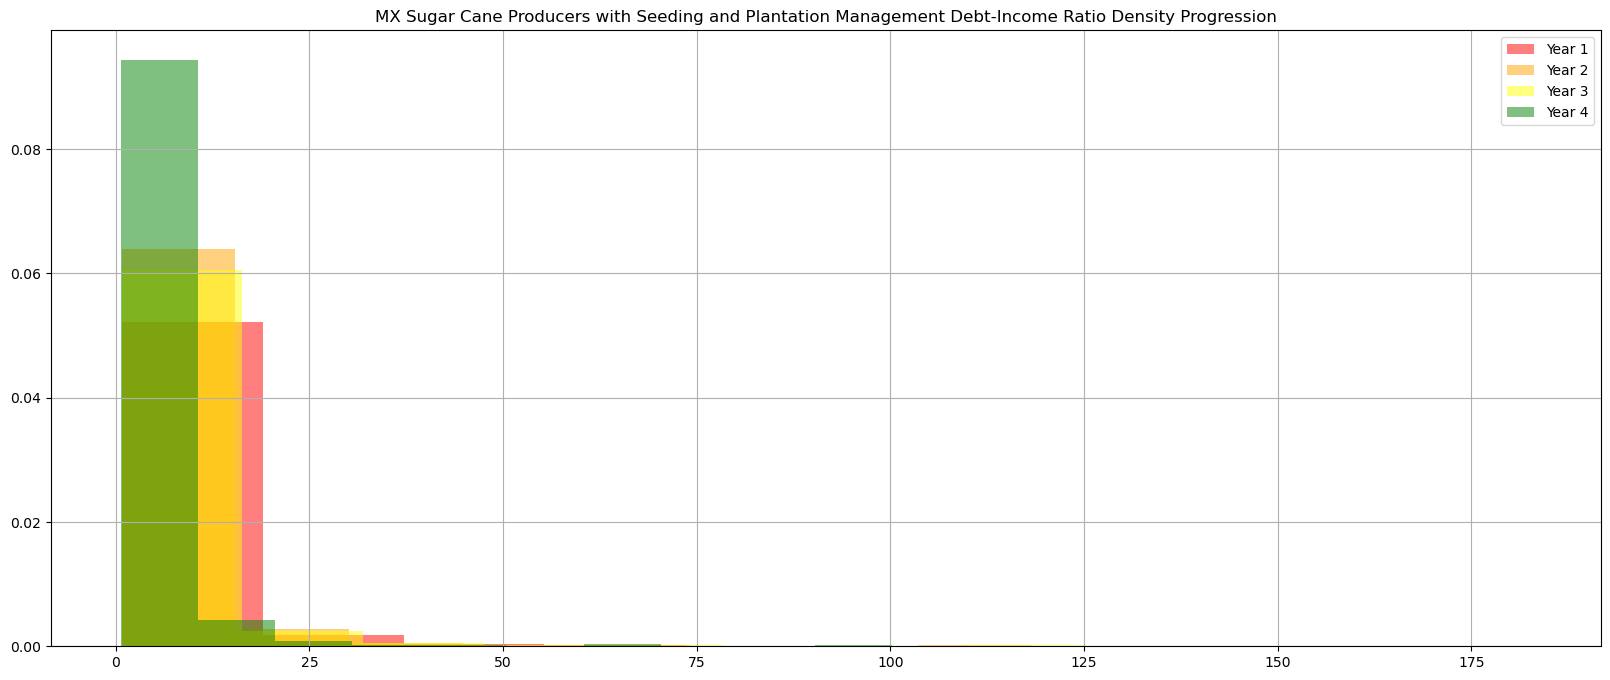

In [21]:
fig, ax = plt.subplots(figsize=(20, 8))
df_pivot_siembra[('DEBT-INCOME RATIO',1)].hist(alpha=0.5,color='red',ax=ax,density=True)
df_pivot_siembra[('DEBT-INCOME RATIO',2)].hist(alpha=0.5,color='orange',ax=ax,density=True)
df_pivot_siembra[('DEBT-INCOME RATIO',3)].hist(alpha=0.5,color='yellow',ax=ax,density=True)
df_pivot_siembra[('DEBT-INCOME RATIO',4)].hist(alpha=0.5,color='green',ax=ax,density=True)
ax.legend(["Year 1","Year 2","Year 3","Year 4"])
ax.set_title('MX Sugar Cane Producers with Seeding and Plantation Management Debt-Income Ratio Density Progression')
df_pivot_siembra[[('DEBT-INCOME RATIO',1),('DEBT-INCOME RATIO',2),('DEBT-INCOME RATIO',3),('DEBT-INCOME RATIO',4)]].describe()

#### Cociente Deuda-Ingreso Productores con Manejo

DEBT-INCOME RATIO                                                
ZAFRA                 0           1           2           3           4
count        729.000000  729.000000  729.000000  729.000000  729.000000
mean           6.724273    6.699235    6.376846    5.550579    3.545533
std           14.029449   12.625225   10.588455    8.908228    4.974589
min            0.623011    0.652893    0.709020    0.676042    0.587446
25%            2.660266    2.899173    2.982512    2.532076    1.662212
50%            3.968951    4.180250    4.241684    3.729744    2.496681
75%            5.909627    5.958142    5.916191    5.175667    3.642285
max          273.542804  231.419300  169.639298  141.240917   77.630373

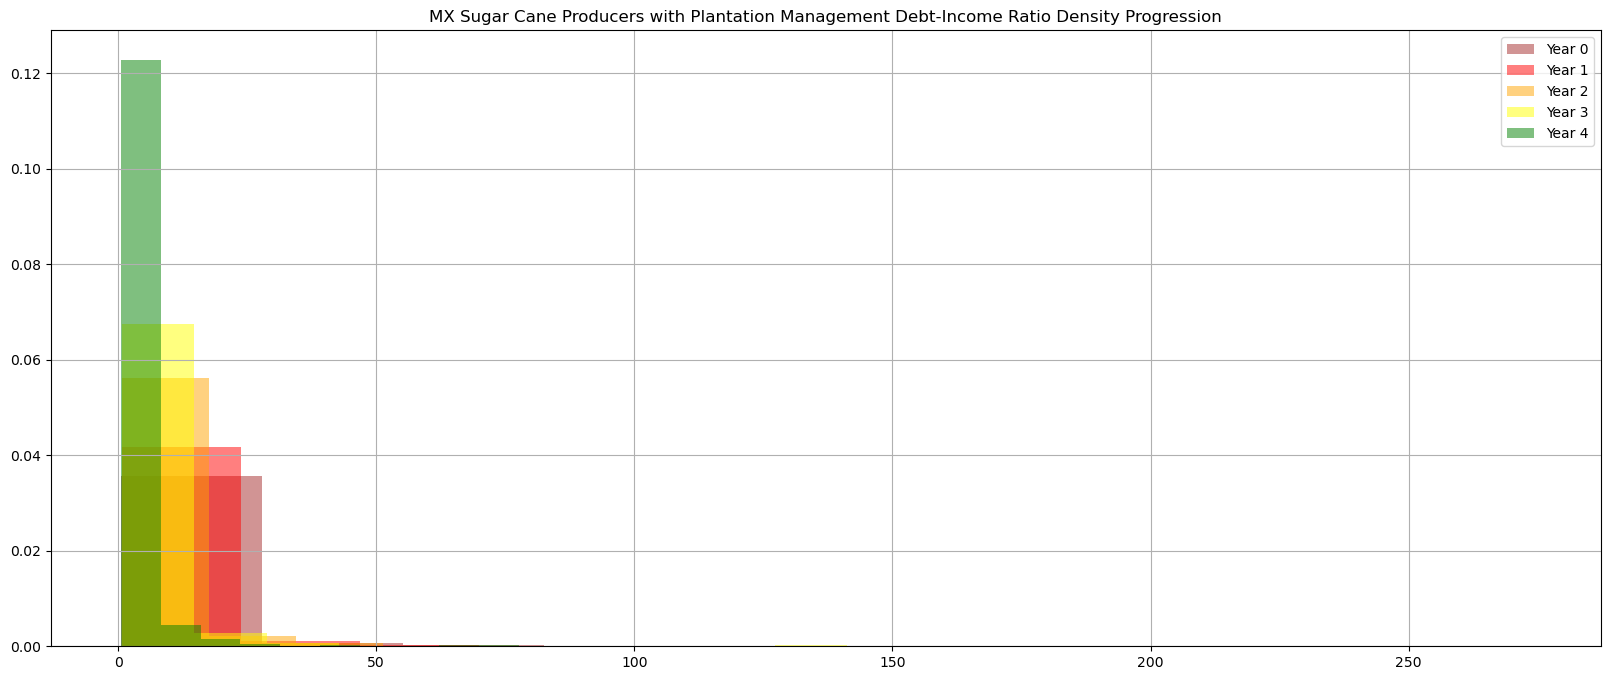

In [22]:
fig, ax = plt.subplots(figsize=(20, 8))
df_pivot_manejo[('DEBT-INCOME RATIO',0)].hist(alpha=0.5,color='brown',ax=ax,density=True)
df_pivot_manejo[('DEBT-INCOME RATIO',1)].hist(alpha=0.5,color='red',ax=ax,density=True)
df_pivot_manejo[('DEBT-INCOME RATIO',2)].hist(alpha=0.5,color='orange',ax=ax,density=True)
df_pivot_manejo[('DEBT-INCOME RATIO',3)].hist(alpha=0.5,color='yellow',ax=ax,density=True)
df_pivot_manejo[('DEBT-INCOME RATIO',4)].hist(alpha=0.5,color='green',ax=ax,density=True)
ax.legend(["Year 0","Year 1","Year 2","Year 3","Year 4"])
ax.set_title('MX Sugar Cane Producers with Plantation Management Debt-Income Ratio Density Progression')
df_pivot_manejo[[('DEBT-INCOME RATIO',0),('DEBT-INCOME RATIO',1),('DEBT-INCOME RATIO',2),('DEBT-INCOME RATIO',3),('DEBT-INCOME RATIO',4)]].describe()

### Clasificación Financiera de Productores

Se presenta un esquema de **clasificación financiera** de los productores, en función de la **Pérdida Esperada**.

La Pérdida Esperada es una estimación del monto financiero que podría perderse en función del **Riesgo de Impago** de un productor.

El **Riesgo de Impago (%)** (también conocido como *Probability of Default*). Normalmente es función de las condiciones económicas del país, las características socio-económicas del solicitante y otros factores externos. Las herramientas utilizadas comprenden el "credit scoring", modelos probabilísticos de estimación basados en históricos (normalmente modelos de regresión logística o de machine learning). Estos enfoques sin embargo requieren disponer de una historia crediticia del solicitante. Para el caso específico en estudio, no se cuenta con esta información por lo que se propone un enfoque alternativo.

#### Cociente Deuda a Ingresos
El cociente *Deuda a Ingreso* (Income-Debt Ratio) es el porcentaje del Ingreso Mensual Bruto que se destina a cubrir obligaciones de Deuda, entre ellas *préstamos, tarifas, impuestos, primas de seguros, etc*. Este cociente (en conjunto con el "credit scoring") es la variable más relevante en la determinación de la *Probabilidad de Impago* y es más sencillo de obtener porque requiere de información crediticia básica del productor.

Debido a esto, formulamos un modelo de *Regresión Logística* de una variable, con la forma:

$$ DefaultProbability = \frac {e^{(\beta_0 + \beta_1 * IncomeDebtRatio)}}{1+e^{(\beta_0 + \beta_1 * IncomeDebtRatio)}}$$

Este modelo supone determinar los coeficientes $\beta_0$ y $\beta_1$ óptimos para la estimación correcta del riesgo. Normalmente esto se realiza de forma similar a una regresión con datos históricos. En este caso no se cuenta con esta información, por lo que se propone un enfoque alternativo por medio de una **estimación de dos puntos**, en la cual se resuelven dos ecuaciones con dos incógnitas.

Suponga que se tiene información de los productores en la que:
- Un cociente deuda-ingreso $R_0$ se asocia con una probabilidad de incumplimiento $P_0$
- Un cociente deuda-ingreso $R_1$ se asocia con una probabilidad de incumplimiento $P_1$

Se resuelven las ecuaciones para encontrar los parámetros de la regresión, con el siguiente resultado:
$$\beta_1 = \frac{1}{R_0-R_1} * [ln(\frac{P_0}{1-P_0}) - ln(\frac{P_1}{1-P_1})]$$
$$\beta_0 = ln(\frac{P_0}{1-P_0}) - \beta_1*R_0$$

Esto permite estimar el **Riesgo de Impago** dados dos puntos de referencia relacionados al **Cociente Deuda-Ingreso**

In [23]:
# Estimación de Dos Puntos (Debt_Income_Ratio, Probability_of_Default)
R_0 = 3    # Ratio Deuda - Ingreso No. 1
P_0 = 0.2  # Probabilidad de Impago asociada al Ratio Deuda-Ingreso No. 1

R_1 = 8    # Ratio Deuda - Ingreso No. 2
P_1 = 0.8  # Probabilidad de Impago asociada al Ratio Deuda-Ingreso No. 2

[Text(0.5, 1.0, 'Riesgo de Impago (%)')]

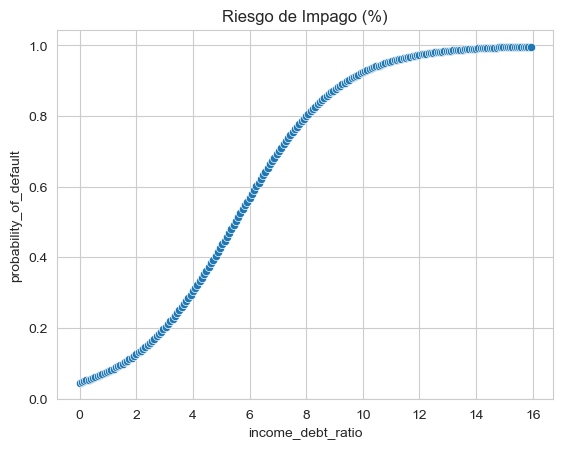

In [24]:
# Coeficientes de Regresión Logística
beta_1 = (1/(R_0-R_1))*(np.log(P_0/(1-P_0))-np.log(P_1/(1-P_1)))
beta_0 = np.log(P_0/(1-P_0))-beta_1*R_0

# Curva Probabilidades de Impago vs. Ratios Deuda-Ingreso
ratios = np.arange(0,R_1*2,R_1/100)
probabilities = 1/(1+np.exp(-(beta_0+beta_1*ratios)))
d = {"income_debt_ratio":ratios,"probability_of_default":probabilities}
prob_df = pd.DataFrame(d)
sns.set_style("whitegrid")
sns.scatterplot(x="income_debt_ratio",y="probability_of_default",data=prob_df).set(title='Riesgo de Impago (%)')

### Probabilidad de Impago Productores con Siembra y Manejo

In [25]:
# Probability of Default as a function of Debt-Income Ratio
df1 = 1/(1+np.exp(-(beta_0+beta_1*df_pivot_siembra['DEBT-INCOME RATIO'])))
df1.columns = [['PROBABILITY OF DEFAULT'] * len(df1.columns), df1.columns]

df_pivot_siembra = df_pivot_siembra.join([df1])

df_pivot_siembra = df_pivot_siembra.sort_index(axis=1)
df_pivot_siembra.head()

AMORTIZACION APS                                  \
ZAFRA                        0        1        2        3    4   
NUMERO CAÑERO                                                    
5101009                    0.0  42750.0  21375.0  21375.0  0.0   
5101013                    0.0  11500.0   5750.0   5750.0  0.0   
5101117                    0.0   1625.0    812.5    812.5  0.0   
5101138                    0.0   4625.0   2312.5   2312.5  0.0   
5101150                    0.0   1250.0    625.0    625.0  0.0   

              AMORTIZACION MANEJO                                      \
ZAFRA                           0        1        2        3        4   
NUMERO CAÑERO                                                           
5101009                       0.0  68400.0  68400.0  68400.0  68400.0   
5101013                       0.0  18400.0  18400.0  18400.0  18400.0   
5101117                       0.0   2600.0   2600.0   2600.0   2600.0   
5101138                       0.0   7400.0   7400.0   7400.0   7400.0   
5101150                       0.0   2000.0   2000.0   2000.0   2000.0   

              AMORTIZACION TOTAL                            Area total         \
ZAFRA                          1        2        3        4          0      1   
NUMERO CAÑERO                                                                   
5101009                 111150.0  89775.0  89775.0  68400.0        0.0  27.00   
5101013                  29900.0  24150.0  24150.0  18400.0        0.0  23.00   
5101117                   4225.0   3412.5   3412.5   2600.0        0.0   3.25   
5101138                  12025.0   9712.5   9712.5   7400.0        0.0   9.25   
5101150                   3250.0   2625.0   2625.0   2000.0        0.0   2.50   

                                    BENEFICIO                              \
ZAFRA              2      3      4          1             2             3   
NUMERO CAÑERO                                                               
5101009        27.00  27.00  27.00  98315.100  75631.269876  71080.996487   
5101013        23.00  23.00  23.00  83749.900  64426.637302  60550.478488   
5101117         3.25   3.25   3.25  11834.225   9103.763967   8556.045873   
5101138         9.25   9.25   9.25  33682.025  25910.712828  24351.822870   
5101150         2.50   2.50   2.50   9103.250   7002.895359   6581.573749   

                             CAT                                            \
ZAFRA                     4    0             1             2             3   
NUMERO CAÑERO                                                                
5101009        69374.617726  0.0  17646.350418  13574.882096  12758.164026   
5101013        59096.896581  0.0  15032.076282  11563.788452  10868.065652   
5101117         8350.648430  0.0   2124.097735   1634.013586   1535.704929   
5101138        23767.230147  0.0   6045.508940   4650.654052   4370.852490   
5101150         6423.575715  0.0   1633.921335   1256.933527   1181.311484   

                            CAÑA TOTAL                                      \
ZAFRA                     4          0         1            2            3   
NUMERO CAÑERO                                                                
5101009        12451.890040        0.0  1512.540  1163.557998  1093.553792   
5101013        10607.165590        0.0  1288.460   991.179035   931.545823   
5101117         1498.838616        0.0   182.065   140.057907   131.631475   
5101138         4265.925292        0.0   518.185   398.626351   374.643429   
5101150         1152.952782        0.0   140.050   107.736852   101.254981   

                           CORTE                          CUOTA CONADESUCA  \
ZAFRA                    4    -1    0    1    2    3    4                0   
NUMERO CAÑERO                                                                
5101009        1067.301811   0.0  0.0  1.0  2.0  3.0  4.0              0.0   
5101013         909.183024   0.0  0.0  1.0  2.0  3.0  4.0              0

### Probabilidad de Impago Productores con Manejo

In [26]:
# Probability of Default as a function of Debt-Income Ratio
df1 = 1/(1+np.exp(-(beta_0+beta_1*df_pivot_manejo['DEBT-INCOME RATIO'])))
df1.columns = [['PROBABILITY OF DEFAULT'] * len(df1.columns), df1.columns]

df_pivot_manejo = df_pivot_manejo.join([df1])

df_pivot_manejo = df_pivot_manejo.sort_index(axis=1)
df_pivot_manejo.head()

AMORTIZACION APS                                   \
ZAFRA                        0         1        2        3    4   
NUMERO CAÑERO                                                     
5101012                    0.0    1250.0    625.0    625.0  0.0   
5101258                    0.0   11000.0   5500.0   5500.0  0.0   
5101259                    0.0   24500.0  12250.0  12250.0  0.0   
5101262                    0.0  104250.0  52125.0  52125.0  0.0   
5101267                    0.0    1250.0    625.0    625.0  0.0   

              AMORTIZACION MANEJO                                          \
ZAFRA                           0         1         2         3         4   
NUMERO CAÑERO                                                               
5101012                    2000.0    2000.0    2000.0    2000.0    2000.0   
5101258                   17600.0   17600.0   17600.0   17600.0   17600.0   
5101259                   39200.0   39200.0   39200.0   39200.0   39200.0   
5101262                  166800.0  166800.0  166800.0  166800.0  166800.0   
5101267                    2000.0    2000.0    2000.0    2000.0    2000.0   

              AMORTIZACION TOTAL                                          \
ZAFRA                          0         1         2         3         4   
NUMERO CAÑERO                                                              
5101012                   2000.0    2000.0    2000.0    2000.0    2000.0   
5101258                  17600.0   17600.0   17600.0   17600.0   17600.0   
5101259                  39200.0   39200.0   39200.0   39200.0   39200.0   
5101262                 166800.0  166800.0  166800.0  166800.0  166800.0   
5101267                   2000.0    2000.0    2000.0    2000.0    2000.0   

              Area total                                  BENEFICIO  \
ZAFRA                  0      1      2      3      4              0   
NUMERO CAÑERO                                                         
5101012             2.50   2.50   2.50   2.50   2.50    9103.250000   
5101258            26.75  26.75  26.75  26.75  26.75   70422.839112   
5101259            10.00  10.00  10.00  10.00  10.00   36413.000000   
5101262            69.00  69.00  69.00  69.00  69.00  227882.850000   
5101267             2.50   2.50   2.50   2.50   2.50    9103.250000   

                                                                           \
ZAFRA                      1              2              3              4   
NUMERO CAÑERO                                                               
5101012          7002.895359    6581.573749    6423.575715    6318.041527   
5101258         68732.260155   67603.044338   67603.044338   67603.044338   
5101259         28011.581436   26326.294995   25694.302862   25272.166108   
5101262        219092.250000  199893.214431  199893.214431  199893.214431   
5101267          7002.895359    6581.573749    6423.575715    6318.041527   

                        CAT                                            \
ZAFRA                     0             1             2             3   
NUMERO CAÑERO                                                           
5101012         1633.921335   1256.933527   1181.311484   1152.952782   
5101258        12640.032878  12336.594762  12133.914421  12133.914421   
5101259         6535.685340   5027.734110   4725.245936   4611.811126   
5101262        40902.166863  39324.362355  35878.371766  35878.371766   
5101267         1633.921335   1256.933527   1181.311484   1152.952782   

                              CAÑA TOTAL                            \
ZAFRA                     4            0            1            2   
NUMERO CAÑERO                                                        
5101012         1134.010694   140.050000   107.736852   101.254981   
5101258        12133.914421  1083.428294  1057.419387  1040.046836   
5101259         4536.042774   560.200000   430.947407   405.019923   
5101262        35878.371766  3505.890000  3370.650000  3075.

### Progresión de la Distribución del Riesgo de Impago

Se presenta la distribuición del Riesgo de Impago de los productores. Por medio de este análisis gráfico puede observarse el comportamiento del riesgo al avanzar los años, de acuerdo con el ratio Deuda-Ingreso proyectado para cada productor.

**Es deseable que la distribución reduzca su media y varianza al transcurrir los años**.

#### Probabilidad de Impago Productores con Siembra y Manejo

PROBABILITY OF DEFAULT                                    
ZAFRA                      1           2           3           4
count             740.000000  740.000000  740.000000  740.000000
mean                0.369164    0.404584    0.391263    0.280676
std                 0.280078    0.276467    0.277962    0.250044
min                 0.068067    0.067430    0.067872    0.064942
25%                 0.166049    0.199724    0.186469    0.123022
50%                 0.256772    0.308576    0.292583    0.185285
75%                 0.456913    0.515821    0.490351    0.303034
max                 1.000000    1.000000    1.000000    1.000000

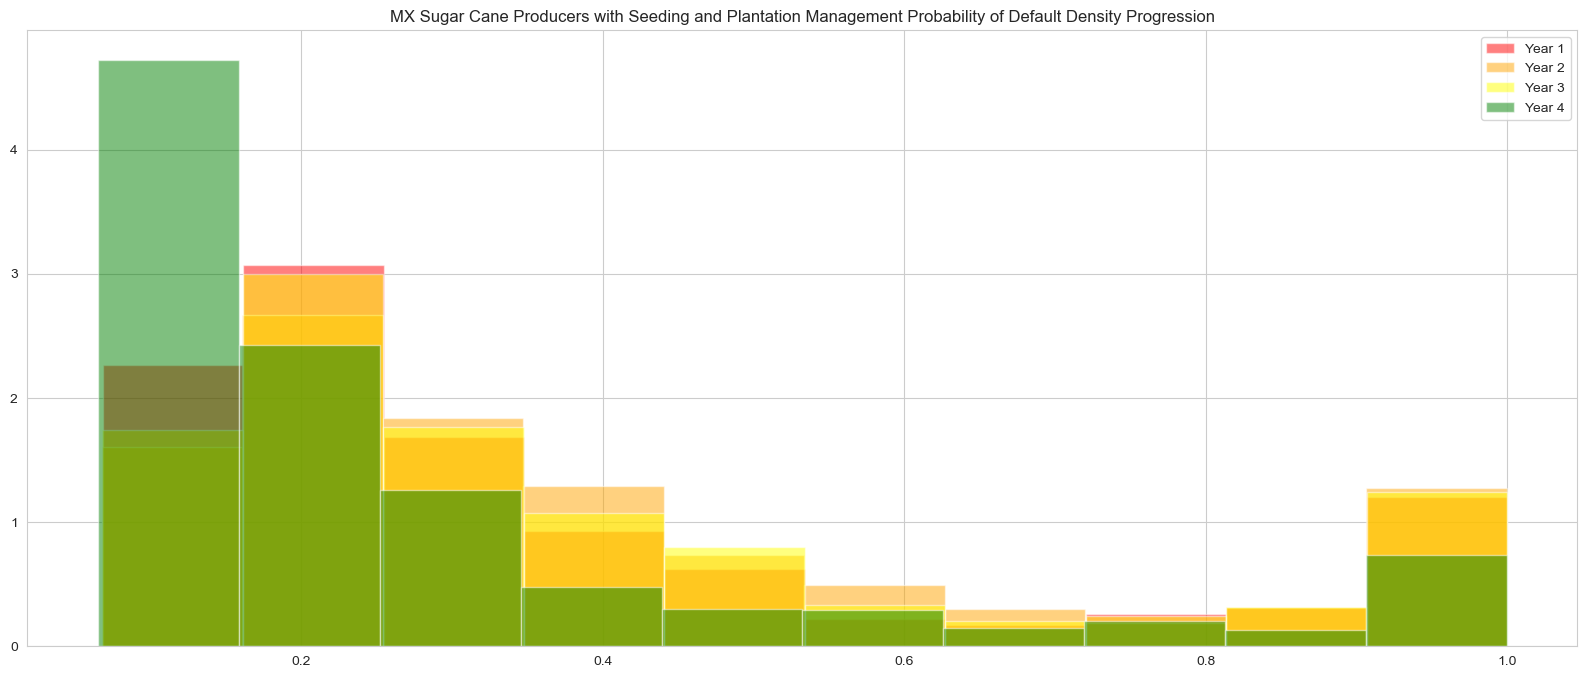

In [27]:
fig, ax = plt.subplots(figsize=(20, 8))
df_pivot_siembra[('PROBABILITY OF DEFAULT',1)].hist(alpha=0.5,color='red',ax=ax,density=True)
df_pivot_siembra[('PROBABILITY OF DEFAULT',2)].hist(alpha=0.5,color='orange',ax=ax,density=True)
df_pivot_siembra[('PROBABILITY OF DEFAULT',3)].hist(alpha=0.5,color='yellow',ax=ax,density=True)
df_pivot_siembra[('PROBABILITY OF DEFAULT',4)].hist(alpha=0.5,color='green',ax=ax,density=True)
ax.legend(["Year 1","Year 2","Year 3","Year 4"])
ax.set_title('MX Sugar Cane Producers with Seeding and Plantation Management Probability of Default Density Progression')
df_pivot_siembra[[('PROBABILITY OF DEFAULT',1),('PROBABILITY OF DEFAULT',2),('PROBABILITY OF DEFAULT',3),('PROBABILITY OF DEFAULT',4)]].describe()

#### Probabilidad de Impago Productores con Manejo

PROBABILITY OF DEFAULT                                                
ZAFRA                      0           1           2           3           4
count             729.000000  729.000000  729.000000  729.000000  729.000000
mean                0.401041    0.418316    0.416265    0.365456    0.243846
std                 0.292337    0.285661    0.277207    0.270099    0.226226
min                 0.062716    0.063697    0.065578    0.064467    0.061566
25%                 0.171550    0.191204    0.198453    0.161682    0.106393
50%                 0.299644    0.324794    0.332309    0.272567    0.159039
75%                 0.556543    0.563173    0.557442    0.455159    0.263058
max                 1.000000    1.000000    1.000000    1.000000    1.000000

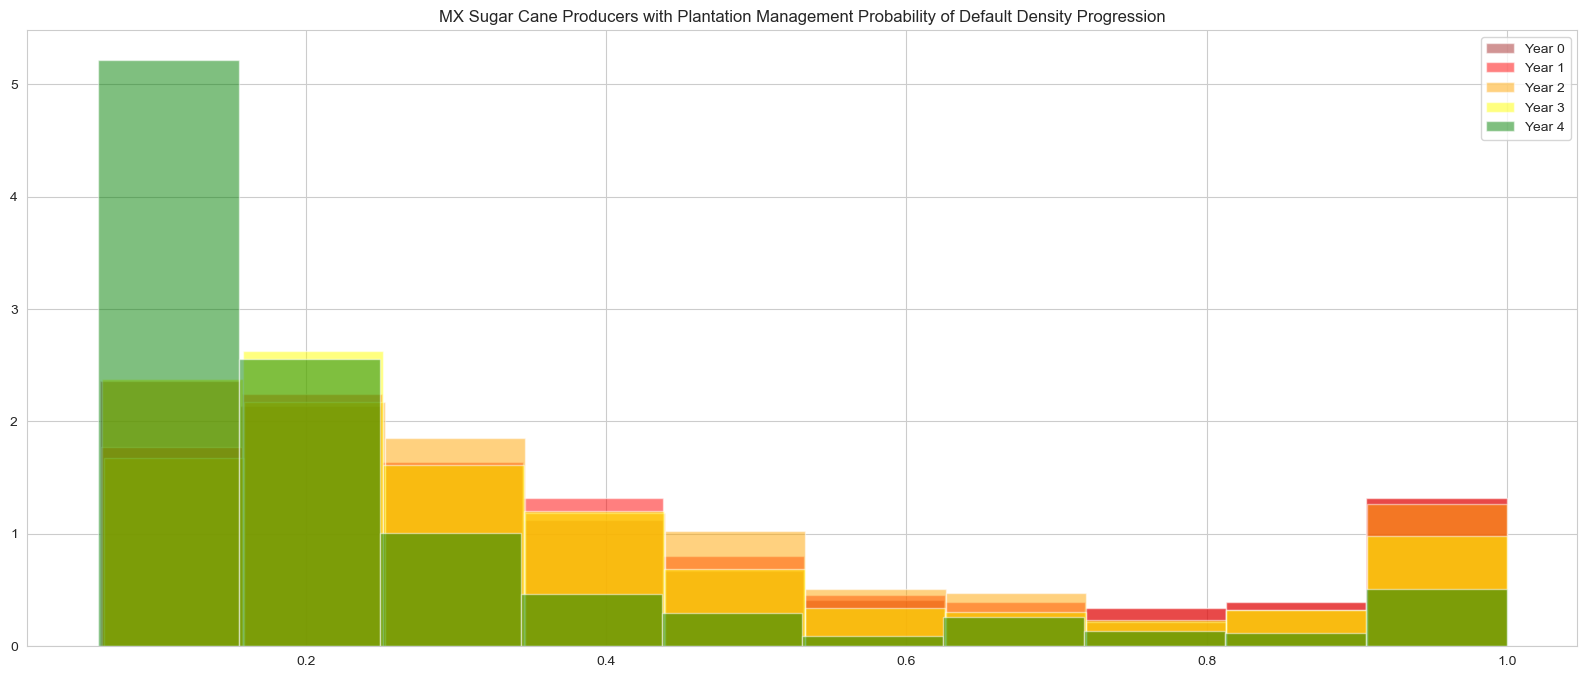

In [28]:
fig, ax = plt.subplots(figsize=(20, 8))
df_pivot_manejo[('PROBABILITY OF DEFAULT',0)].hist(alpha=0.5,color='brown',ax=ax,density=True)
df_pivot_manejo[('PROBABILITY OF DEFAULT',1)].hist(alpha=0.5,color='red',ax=ax,density=True)
df_pivot_manejo[('PROBABILITY OF DEFAULT',2)].hist(alpha=0.5,color='orange',ax=ax,density=True)
df_pivot_manejo[('PROBABILITY OF DEFAULT',3)].hist(alpha=0.5,color='yellow',ax=ax,density=True)
df_pivot_manejo[('PROBABILITY OF DEFAULT',4)].hist(alpha=0.5,color='green',ax=ax,density=True)
ax.legend(["Year 0","Year 1","Year 2","Year 3","Year 4"])
ax.set_title('MX Sugar Cane Producers with Plantation Management Probability of Default Density Progression')
df_pivot_manejo[[('PROBABILITY OF DEFAULT',0),('PROBABILITY OF DEFAULT',1),('PROBABILITY OF DEFAULT',2),('PROBABILITY OF DEFAULT',3),('PROBABILITY OF DEFAULT',4)]].describe()

### Cálculo de Pérdida Esperada

#### Pérdida Esperada Productores con Siembra y Manejo

In [29]:
### Pérdida Esperada
df1 = df_pivot_siembra['PROBABILITY OF DEFAULT']*df_pivot_siembra['AMORTIZACION TOTAL']
df1.columns = [['PERDIDA ESPERADA'] * len(df1.columns), df1.columns]
df_pivot_siembra = df_pivot_siembra.join([df1])

df_pivot_siembra = df_pivot_siembra.sort_index(axis=1)
df_pivot_siembra.head()

AMORTIZACION APS                                  \
ZAFRA                        0        1        2        3    4   
NUMERO CAÑERO                                                    
5101009                    0.0  42750.0  21375.0  21375.0  0.0   
5101013                    0.0  11500.0   5750.0   5750.0  0.0   
5101117                    0.0   1625.0    812.5    812.5  0.0   
5101138                    0.0   4625.0   2312.5   2312.5  0.0   
5101150                    0.0   1250.0    625.0    625.0  0.0   

              AMORTIZACION MANEJO                                      \
ZAFRA                           0        1        2        3        4   
NUMERO CAÑERO                                                           
5101009                       0.0  68400.0  68400.0  68400.0  68400.0   
5101013                       0.0  18400.0  18400.0  18400.0  18400.0   
5101117                       0.0   2600.0   2600.0   2600.0   2600.0   
5101138                       0.0   7400.0   7400.0   7400.0   7400.0   
5101150                       0.0   2000.0   2000.0   2000.0   2000.0   

              AMORTIZACION TOTAL                            Area total         \
ZAFRA                          1        2        3        4          0      1   
NUMERO CAÑERO                                                                   
5101009                 111150.0  89775.0  89775.0  68400.0        0.0  27.00   
5101013                  29900.0  24150.0  24150.0  18400.0        0.0  23.00   
5101117                   4225.0   3412.5   3412.5   2600.0        0.0   3.25   
5101138                  12025.0   9712.5   9712.5   7400.0        0.0   9.25   
5101150                   3250.0   2625.0   2625.0   2000.0        0.0   2.50   

                                    BENEFICIO                              \
ZAFRA              2      3      4          1             2             3   
NUMERO CAÑERO                                                               
5101009        27.00  27.00  27.00  98315.100  75631.269876  71080.996487   
5101013        23.00  23.00  23.00  83749.900  64426.637302  60550.478488   
5101117         3.25   3.25   3.25  11834.225   9103.763967   8556.045873   
5101138         9.25   9.25   9.25  33682.025  25910.712828  24351.822870   
5101150         2.50   2.50   2.50   9103.250   7002.895359   6581.573749   

                             CAT                                            \
ZAFRA                     4    0             1             2             3   
NUMERO CAÑERO                                                                
5101009        69374.617726  0.0  17646.350418  13574.882096  12758.164026   
5101013        59096.896581  0.0  15032.076282  11563.788452  10868.065652   
5101117         8350.648430  0.0   2124.097735   1634.013586   1535.704929   
5101138        23767.230147  0.0   6045.508940   4650.654052   4370.852490   
5101150         6423.575715  0.0   1633.921335   1256.933527   1181.311484   

                            CAÑA TOTAL                                      \
ZAFRA                     4          0         1            2            3   
NUMERO CAÑERO                                                                
5101009        12451.890040        0.0  1512.540  1163.557998  1093.553792   
5101013        10607.165590        0.0  1288.460   991.179035   931.545823   
5101117         1498.838616        0.0   182.065   140.057907   131.631475   
5101138         4265.925292        0.0   518.185   398.626351   374.643429   
5101150         1152.952782        0.0   140.050   107.736852   101.254981   

                           CORTE                          CUOTA CONADESUCA  \
ZAFRA                    4    -1    0    1    2    3    4                0   
NUMERO CAÑERO                                                                
5101009        1067.301811   0.0  0.0  1.0  2.0  3.0  4.0              0.0   
5101013         909.183024   0.0  0.0  1.0  2.0  3.0  4.0              0

PERDIDA ESPERADA                                             
ZAFRA                1              2              3              4
count       740.000000     740.000000     740.000000     740.000000
mean       6093.834206    5124.920130    5001.498132    2834.682094
std       15089.248756   12158.898822   12149.275775    8166.674074
min          83.940073      81.069893      89.303748      58.408301
25%        1295.182774    1248.232063    1220.687143     612.443097
50%        2096.980833    2083.763667    1930.638011     977.817869
75%        4560.586146    3746.004112    3725.154522    1677.853025
max      198900.000000  160650.000000  160650.000000  122400.000000

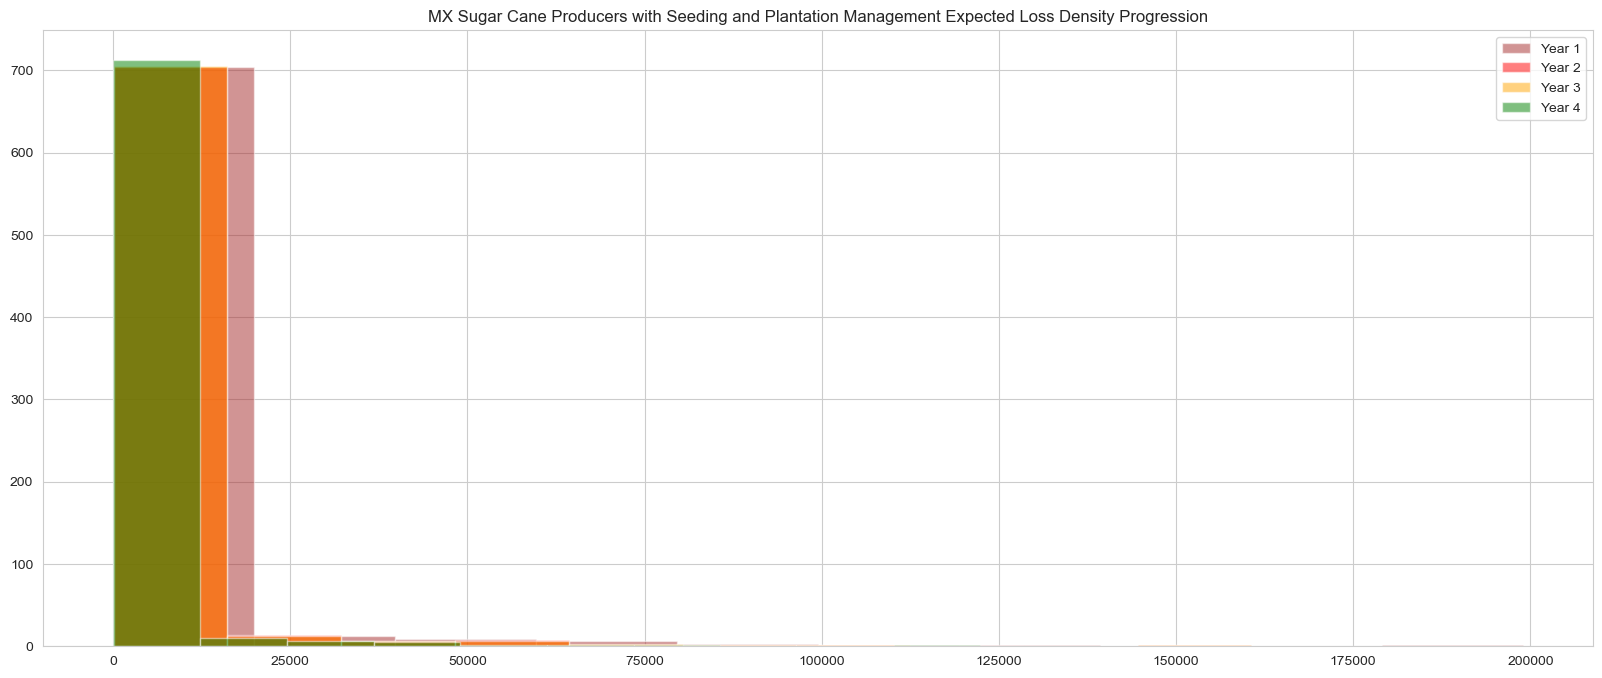

In [30]:
fig, ax = plt.subplots(figsize=(20, 8))
df_pivot_siembra[('PERDIDA ESPERADA',1)].hist(alpha=0.5,color='brown',ax=ax)
df_pivot_siembra[('PERDIDA ESPERADA',2)].hist(alpha=0.5,color='red',ax=ax)
df_pivot_siembra[('PERDIDA ESPERADA',3)].hist(alpha=0.5,color='orange',ax=ax)
df_pivot_siembra[('PERDIDA ESPERADA',4)].hist(alpha=0.5,color='green',ax=ax)
ax.legend(["Year 1","Year 2","Year 3","Year 4"])
ax.set_title('MX Sugar Cane Producers with Seeding and Plantation Management Expected Loss Density Progression')
df_pivot_siembra[[('PERDIDA ESPERADA',1),('PERDIDA ESPERADA',2),('PERDIDA ESPERADA',3),('PERDIDA ESPERADA',4)]].describe()

In [33]:
df_loss_siembra = pd.DataFrame(df_pivot_siembra[('PERDIDA ESPERADA')].sum(axis=1))
df_loss_siembra.columns = ['TOTAL EXPECTED LOSS']
df_loss_siembra.head()

,TOTAL EXPECTED LOSS
NUMERO CAÑERO,
5101009,315764.916281
5101013,14271.802116
5101117,5653.717507
5101138,8649.088132
5101150,5954.754398


#### Pérdida Esperada Productores con Manejo

In [31]:
### Pérdida Esperada
df1 = df_pivot_manejo['PROBABILITY OF DEFAULT']*df_pivot_manejo['AMORTIZACION TOTAL']
df1.columns = [['PERDIDA ESPERADA'] * len(df1.columns), df1.columns]
df_pivot_manejo = df_pivot_manejo.join([df1])

df_pivot_manejo = df_pivot_manejo.sort_index(axis=1)
df_pivot_manejo.head()

AMORTIZACION APS                                   \
ZAFRA                        0         1        2        3    4   
NUMERO CAÑERO                                                     
5101012                    0.0    1250.0    625.0    625.0  0.0   
5101258                    0.0   11000.0   5500.0   5500.0  0.0   
5101259                    0.0   24500.0  12250.0  12250.0  0.0   
5101262                    0.0  104250.0  52125.0  52125.0  0.0   
5101267                    0.0    1250.0    625.0    625.0  0.0   

              AMORTIZACION MANEJO                                          \
ZAFRA                           0         1         2         3         4   
NUMERO CAÑERO                                                               
5101012                    2000.0    2000.0    2000.0    2000.0    2000.0   
5101258                   17600.0   17600.0   17600.0   17600.0   17600.0   
5101259                   39200.0   39200.0   39200.0   39200.0   39200.0   
5101262                  166800.0  166800.0  166800.0  166800.0  166800.0   
5101267                    2000.0    2000.0    2000.0    2000.0    2000.0   

              AMORTIZACION TOTAL                                          \
ZAFRA                          0         1         2         3         4   
NUMERO CAÑERO                                                              
5101012                   2000.0    2000.0    2000.0    2000.0    2000.0   
5101258                  17600.0   17600.0   17600.0   17600.0   17600.0   
5101259                  39200.0   39200.0   39200.0   39200.0   39200.0   
5101262                 166800.0  166800.0  166800.0  166800.0  166800.0   
5101267                   2000.0    2000.0    2000.0    2000.0    2000.0   

              Area total                                  BENEFICIO  \
ZAFRA                  0      1      2      3      4              0   
NUMERO CAÑERO                                                         
5101012             2.50   2.50   2.50   2.50   2.50    9103.250000   
5101258            26.75  26.75  26.75  26.75  26.75   70422.839112   
5101259            10.00  10.00  10.00  10.00  10.00   36413.000000   
5101262            69.00  69.00  69.00  69.00  69.00  227882.850000   
5101267             2.50   2.50   2.50   2.50   2.50    9103.250000   

                                                                           \
ZAFRA                      1              2              3              4   
NUMERO CAÑERO                                                               
5101012          7002.895359    6581.573749    6423.575715    6318.041527   
5101258         68732.260155   67603.044338   67603.044338   67603.044338   
5101259         28011.581436   26326.294995   25694.302862   25272.166108   
5101262        219092.250000  199893.214431  199893.214431  199893.214431   
5101267          7002.895359    6581.573749    6423.575715    6318.041527   

                        CAT                                            \
ZAFRA                     0             1             2             3   
NUMERO CAÑERO                                                           
5101012         1633.921335   1256.933527   1181.311484   1152.952782   
5101258        12640.032878  12336.594762  12133.914421  12133.914421   
5101259         6535.685340   5027.734110   4725.245936   4611.811126   
5101262        40902.166863  39324.362355  35878.371766  35878.371766   
5101267         1633.921335   1256.933527   1181.311484   1152.952782   

                              CAÑA TOTAL                            \
ZAFRA                     4            0            1            2   
NUMERO CAÑERO                                                        
5101012         1134.010694   140.050000   107.736852   101.254981   
5101258        12133.914421  1083.428294  1057.419387  1040.046836   
5101259         4536.042774   560.200000   430.947407   405.019923   
5101262        35878.371766  3505.890000  3370.650000  3075.

PERDIDA ESPERADA                                               \
ZAFRA                0              1              2              3   
count       729.000000     729.000000     729.000000     729.000000   
mean       3457.065151    3612.964665    3611.920205    3207.525773   
std        9098.412764    9347.394454    9686.969419    8932.902704   
min          40.787708      40.931109      41.031163      39.828438   
25%         846.894611     965.802781     987.727300     842.610916   
50%        1427.605264    1535.215929    1603.423798    1323.938925   
75%        3006.898086    3060.683926    2924.718728    2350.639305   
max      146055.023145  149259.549077  155406.480685  137260.375632   

                     
ZAFRA             4  
count    729.000000  
mean    2068.379992  
std     5687.527999  
min       37.520683  
25%      555.251627  
50%      834.743029  
75%     1344.640944  
max    80000.000000

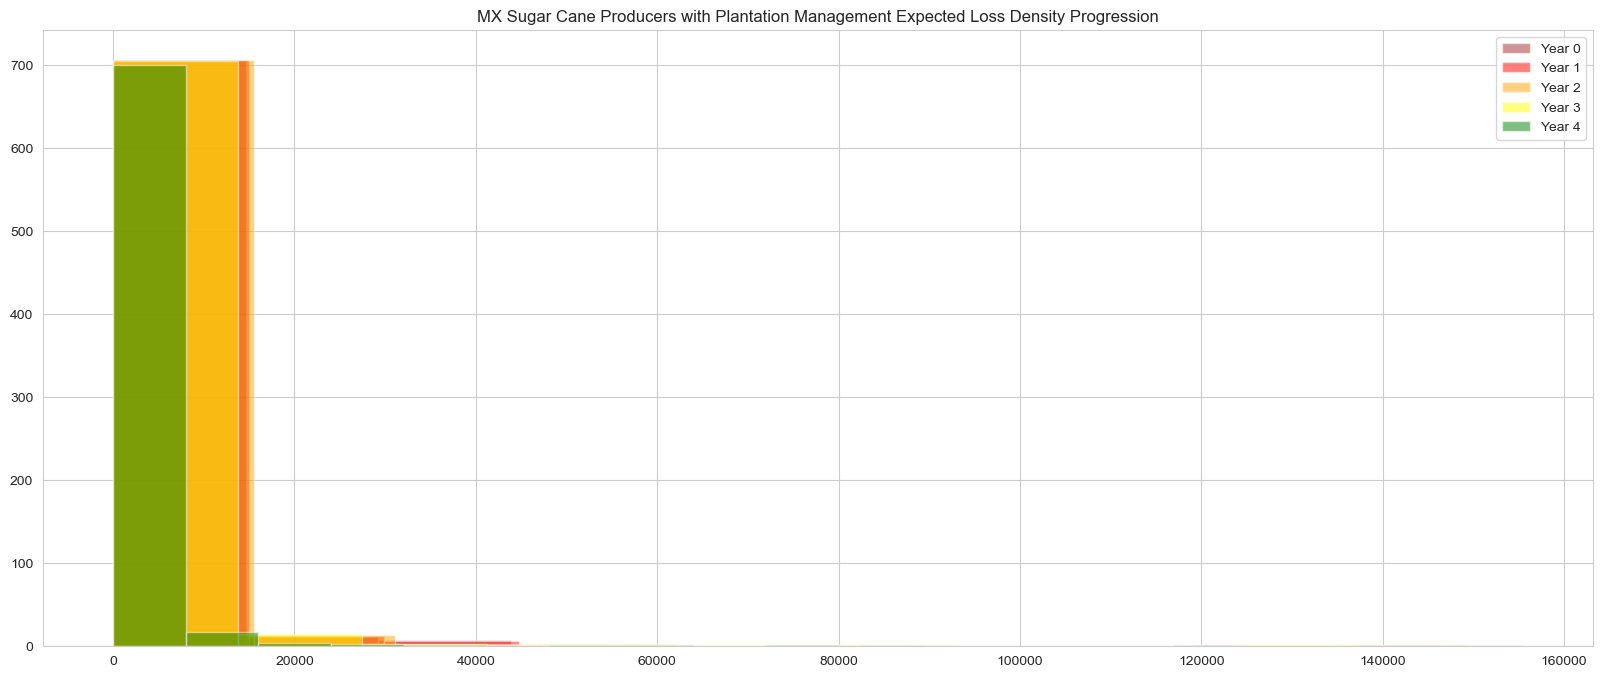

In [32]:
fig, ax = plt.subplots(figsize=(20, 8))
df_pivot_manejo[('PERDIDA ESPERADA',0)].hist(alpha=0.5,color='brown',ax=ax)
df_pivot_manejo[('PERDIDA ESPERADA',1)].hist(alpha=0.5,color='red',ax=ax)
df_pivot_manejo[('PERDIDA ESPERADA',2)].hist(alpha=0.5,color='orange',ax=ax)
df_pivot_manejo[('PERDIDA ESPERADA',3)].hist(alpha=0.5,color='yellow',ax=ax)
df_pivot_manejo[('PERDIDA ESPERADA',4)].hist(alpha=0.5,color='green',ax=ax)
ax.legend(["Year 0","Year 1","Year 2","Year 3","Year 4"])
ax.set_title('MX Sugar Cane Producers with Plantation Management Expected Loss Density Progression')
df_pivot_manejo[[('PERDIDA ESPERADA',0),('PERDIDA ESPERADA',1),('PERDIDA ESPERADA',2),('PERDIDA ESPERADA',3),('PERDIDA ESPERADA',4)]].describe()

In [34]:
df_loss_manejo = pd.DataFrame(df_pivot_manejo[('PERDIDA ESPERADA')].sum(axis=1))
df_loss_manejo.columns = ['TOTAL EXPECTED LOSS']
df_loss_manejo.head()

,TOTAL EXPECTED LOSS
NUMERO CAÑERO,
5101012,2382.301158
5101258,9086.775783
5101259,188175.774871
5101262,646417.666809
5101267,1529.789701


### Clasificación de Productores

La clasificación de los productores se realizar asignando una categoría A, B, C, D,... en función de la Pérdida Esperada estimada para cada uno.


#### Clasificación Ordinal

Esta es una clasificación respecto al orden de la pérdida, y es función de la distribución de valores de pérdida.

Por ejemplo, se muestra abajo:
- Categoría 1 (A): 20% de los productores con pérdida esperada más baja.
- Categoría 2 (B): 30% de los productores con la siguiente pérdida esperada más baja.
- Categoría 3 (C): 35% de los productores con la siguiente pérdida esperada más baja.
- Categoría 4 (D): 15% de los productores con la pérdida esperada más alta.

#### Clasificación Ordinal de Productores con Siembra y Manejo

               TOTAL EXPECTED LOSS CLASS
NUMERO CAÑERO                           
5101009              315764.916281     D
5101013               14271.802116     C
5101117                5653.717507     B
5101138                8649.088132     C
5101150                5954.754398     B


<Axes: xlabel='CLASS', ylabel='Count'>

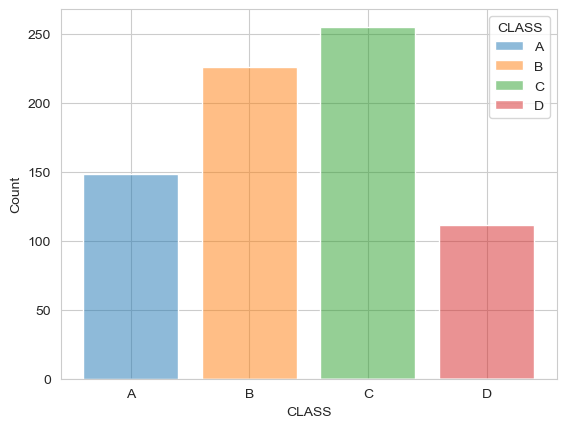

In [36]:
# Clasificación de Productores
df_loss_siembra['CLASS'] = pd.qcut(df_loss_siembra[('TOTAL EXPECTED LOSS')], q=[0,.2,.5,.85,1], labels=['A','B','C','D'])
print(df_loss_siembra.head())
sns.histplot(data=df_loss_siembra, x='CLASS',hue='CLASS',shrink=.8)

#### Clasificación Ordinal de Productores con Manejo

               TOTAL EXPECTED LOSS CLASS
NUMERO CAÑERO                           
5101012                2382.301158     A
5101258                9086.775783     C
5101259              188175.774871     D
5101262              646417.666809     D
5101267                1529.789701     A


<Axes: xlabel='CLASS', ylabel='Count'>

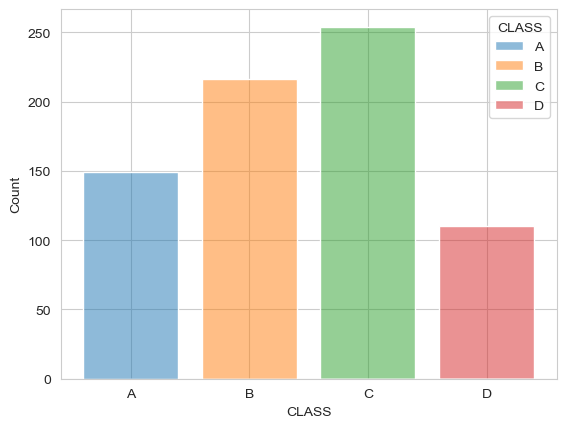

In [37]:
# Clasificación de Productores
df_loss_manejo['CLASS'] = pd.qcut(df_loss_manejo[('TOTAL EXPECTED LOSS')], q=[0,.2,.5,.85,1], labels=['A','B','C','D'])
print(df_loss_manejo.head())
sns.histplot(data=df_loss_manejo, x='CLASS',hue='CLASS',shrink=.8)

#### Clasificación por Rangos

Esta es una clasificación respecto a rangos establecidos de pérdida.

Por ejemplo, se muestra abajo:
- Categoría 1 (A): Los productores con pérdida esperada entre 0 y 6000.
- Categoría 2 (B): Los productores con pérdida esperada entre 6000 y 10000.
- Categoría 3 (C): Los productores con pérdida esperada entre 10000 y 30000.
- Categoría 4 (D): Los productores con pérdida esperada entre 30000 y 150000.
- Categoría 5 (E): Los productores con pérdida esperada mayores a 150000.

#### Clasificación por Rangos de Productores con Siembra y Manejo

               TOTAL EXPECTED LOSS CLASS
NUMERO CAÑERO                           
5101009              315764.916281     E
5101013               14271.802116     C
5101117                5653.717507     A
5101138                8649.088132     B
5101150                5954.754398     A


<Axes: xlabel='CLASS', ylabel='Count'>

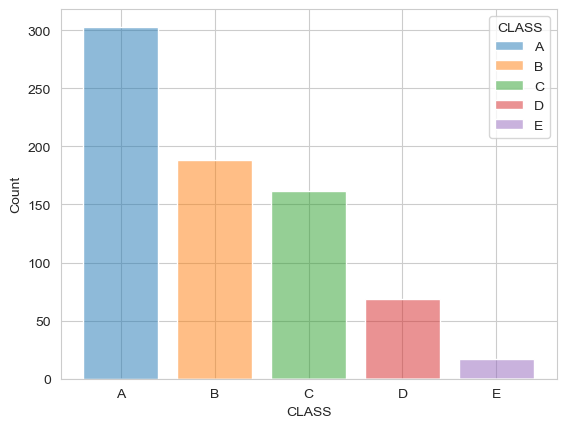

In [38]:
df_loss_siembra['CLASS'] = pd.cut(x=df_loss_siembra['TOTAL EXPECTED LOSS'], bins=[0, 6000, 10000, 30000, 150000,500000],
                    labels=['A','B','C','D','E'])
print(df_loss_siembra.head())
sns.histplot(data=df_loss_siembra, x='CLASS',hue='CLASS',shrink=.8)

#### Clasificación por Rangos de Productores con Manejo

               TOTAL EXPECTED LOSS CLASS
NUMERO CAÑERO                           
5101012                2382.301158     A
5101258                9086.775783     B
5101259              188175.774871     E
5101262              646417.666809     E
5101267                1529.789701     A


<Axes: xlabel='CLASS', ylabel='Count'>

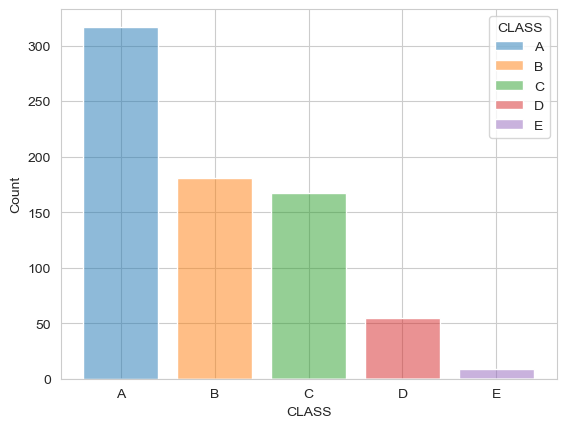

In [40]:
df_loss_manejo['CLASS'] = pd.cut(x=df_loss_manejo['TOTAL EXPECTED LOSS'], bins=[0, 6000, 10000, 30000, 150000,700000],
                    labels=['A','B','C','D','E'])
print(df_loss_manejo.head())
sns.histplot(data=df_loss_manejo, x='CLASS',hue='CLASS',shrink=.8)